In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import shap
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
df = pd.read_csv("/Users/gabifilpo/Downloads/fifa_cleaned_final/fifa_cleaned_all_columns.csv")
df.head()

,Unnamed: 0,sofifa_id,short_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,...,body_Stocky,body_Unique,right_foot,left_foot,injury_risk,teamwork,passing_traits,attacking_traits,dribbling_traits,defending_traits
0,0,158023,L. Messi,CF,93,95,100500000.0,550000.0,27,169,...,0,0,3,5,0,1,0,1,1,0
1,1,20801,Cristiano Ronaldo,"LW, LM",92,92,79000000.0,375000.0,29,185,...,0,0,5,4,0,0,0,1,1,0
2,2,9014,A. Robben,"RM, LM, RW",90,90,54500000.0,275000.0,30,180,...,0,0,2,5,1,-1,0,2,1,0
3,3,41236,Z. Ibrahimović,ST,90,90,52500000.0,275000.0,32,195,...,0,0,5,4,0,1,0,1,1,0
4,5,41,Iniesta,"CM, LW",89,89,36000000.0,250000.0,30,170,...,0,0,5,4,0,0,1,1,1,0


In [3]:
df['club_season'] = df.club_name.astype(str) + " " + df.season.astype(str)
df.player_positions = df.player_positions.apply(lambda x: x.split(',')[0])
df["new_pos"] = df.player_positions.apply(lambda x: "D" if x in ['LWB', 'LB', 'LCB', 'CB', 'RCB', 'RB', 'RWB']
                                                else "ND")
df.head()

,Unnamed: 0,sofifa_id,short_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,...,right_foot,left_foot,injury_risk,teamwork,passing_traits,attacking_traits,dribbling_traits,defending_traits,club_season,new_pos
0,0,158023,L. Messi,CF,93,95,100500000.0,550000.0,27,169,...,3,5,0,1,0,1,1,0,FC Barcelona 1415,ND
1,1,20801,Cristiano Ronaldo,LW,92,92,79000000.0,375000.0,29,185,...,5,4,0,0,0,1,1,0,Real Madrid CF 1415,ND
2,2,9014,A. Robben,RM,90,90,54500000.0,275000.0,30,180,...,2,5,1,-1,0,2,1,0,FC Bayern München 1415,ND
3,3,41236,Z. Ibrahimović,ST,90,90,52500000.0,275000.0,32,195,...,5,4,0,1,0,1,1,0,Paris Saint-Germain 1415,ND
4,5,41,Iniesta,CM,89,89,36000000.0,250000.0,30,170,...,5,4,0,0,1,1,1,0,FC Barcelona 1415,ND


In [4]:
#Get all the defenders 
df_def = df[df.new_pos == 'D'].groupby('club_season').head(8).reset_index(drop=True).sort_values(by=['overall'], 
                                                                                                       ascending=False)
df_def.head()

,Unnamed: 0,sofifa_id,short_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,...,right_foot,left_foot,injury_risk,teamwork,passing_traits,attacking_traits,dribbling_traits,defending_traits,club_season,new_pos
18986,3,155862,Sergio Ramos,CB,91,91,51000000.0,375000.0,32,184,...,5,3,0,2,0,0,0,2,Real Madrid CF 1819,D
24034,8,203376,V. van Dijk,CB,90,91,78000000.0,200000.0,27,193,...,5,3,-1,1,1,0,0,1,Liverpool 1920,D
9005,7,183907,J. Boateng,CB,90,90,56000000.0,200000.0,27,192,...,5,4,0,0,1,0,0,0,FC Bayern München 1617,D
29212,7,203376,V. van Dijk,CB,90,91,113000000.0,210000.0,28,193,...,5,3,-1,1,1,0,0,1,Liverpool 2021,D
13957,6,155862,Sergio Ramos,CB,90,90,52000000.0,300000.0,31,183,...,5,3,0,1,0,0,0,2,Real Madrid CF 1718,D


In [5]:
df_def.groupby('club_season').count().club_name.describe()

count    5153.000000
mean        7.745197
std         0.646365
min         0.000000
25%         8.000000
50%         8.000000
75%         8.000000
max         8.000000
Name: club_name, dtype: float64

In [6]:
df_notdef = df[df.new_pos == 'ND'].groupby('club_season').head(12).reset_index(drop=True).sort_values(
                                         by=['overall'], ascending=False)
df_notdef.head()

,Unnamed: 0,sofifa_id,short_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,...,right_foot,left_foot,injury_risk,teamwork,passing_traits,attacking_traits,dribbling_traits,defending_traits,club_season,new_pos
21507,0,20801,Cristiano Ronaldo,LW,94,94,95500000.0,575000.0,32,185,...,5,4,0,0,1,1,1,0,Real Madrid CF 1718,ND
6930,0,158023,L. Messi,RW,94,95,111000000.0,550000.0,28,170,...,4,5,0,1,0,1,1,0,FC Barcelona 1516,ND
29239,0,20801,Cristiano Ronaldo,ST,94,94,77000000.0,400000.0,33,187,...,5,4,0,0,1,1,1,0,Juventus 1819,ND
29240,1,158023,L. Messi,CF,94,94,110500000.0,575000.0,31,170,...,4,5,0,0,1,3,1,0,FC Barcelona 1819,ND
13954,0,20801,Cristiano Ronaldo,LW,94,94,87000000.0,575000.0,31,185,...,5,4,0,0,0,1,1,0,Real Madrid CF 1617,ND


In [7]:
df_notdef.groupby('club_season').count().club_name.describe()

count    5153.000000
mean       11.913448
std         0.592624
min         0.000000
25%        12.000000
50%        12.000000
75%        12.000000
max        12.000000
Name: club_name, dtype: float64

In [8]:
all_players = pd.concat([df_notdef, df_def])
all_players.head()

,Unnamed: 0,sofifa_id,short_name,player_positions,overall,potential,value_eur,wage_eur,age,height_cm,...,right_foot,left_foot,injury_risk,teamwork,passing_traits,attacking_traits,dribbling_traits,defending_traits,club_season,new_pos
21507,0,20801,Cristiano Ronaldo,LW,94,94,95500000.0,575000.0,32,185,...,5,4,0,0,1,1,1,0,Real Madrid CF 1718,ND
6930,0,158023,L. Messi,RW,94,95,111000000.0,550000.0,28,170,...,4,5,0,1,0,1,1,0,FC Barcelona 1516,ND
29239,0,20801,Cristiano Ronaldo,ST,94,94,77000000.0,400000.0,33,187,...,5,4,0,0,1,1,1,0,Juventus 1819,ND
29240,1,158023,L. Messi,CF,94,94,110500000.0,575000.0,31,170,...,4,5,0,0,1,3,1,0,FC Barcelona 1819,ND
13954,0,20801,Cristiano Ronaldo,LW,94,94,87000000.0,575000.0,31,185,...,5,4,0,0,0,1,1,0,Real Madrid CF 1617,ND


In [9]:
#drop clubs that have less than 20 players 
keep_clubs = list(all_players.groupby('club_season').count()[all_players.groupby('club_season').count(
             ).club_name == 20].index)

In [10]:
train_team = all_players.groupby('club_season').mean().iloc[:, 1:].reset_index()
train_team.head()

,club_season,sofifa_id,overall,potential,value_eur,wage_eur,age,height_cm,weight_kg,league_level,...,body_Stocky,body_Unique,right_foot,left_foot,injury_risk,teamwork,passing_traits,attacking_traits,dribbling_traits,defending_traits
0,1. FC Heidenheim 1846 1415,205125.550000,62.800000,66.650000,354000.0,2500.000000,24.750000,183.500000,79.500000,2.0,...,0.00,0.0,4.400000,3.850000,0.050000,0.00,0.00,0.100000,0.000000,0.0
1,1. FC Heidenheim 1846 1516,203422.800000,65.950000,69.250000,725000.0,7500.000000,25.500000,183.200000,79.450000,2.0,...,0.05,0.0,4.400000,3.700000,0.050000,0.05,0.00,0.200000,0.150000,0.0
2,1. FC Heidenheim 1846 1617,205915.105263,67.052632,71.105263,950000.0,5736.842105,24.736842,182.894737,77.789474,2.0,...,0.00,0.0,4.473684,3.526316,0.052632,0.00,0.00,0.157895,0.105263,0.0
3,1. FC Heidenheim 1846 1718,208721.300000,67.550000,70.850000,1312500.0,9500.000000,25.500000,184.150000,80.000000,2.0,...,0.00,0.0,4.350000,3.700000,-0.050000,0.05,0.10,0.100000,0.150000,0.0
4,1. FC Heidenheim 1846 1819,215430.400000,67.450000,71.650000,1165000.0,5900.000000,25.250000,184.450000,79.450000,2.0,...,0.00,0.0,4.350000,3.700000,-0.050000,0.05,0.25,0.100000,0.100000,0.0


In [11]:
len(train_team)

5153

# Supervised Part

In [12]:
scores = pd.read_csv("/Users/gabifilpo/Downloads/all_league_combined.csv")

In [13]:
scores.Team = scores.Team.apply(lambda x: x.split("(")[0].rstrip())

In [14]:
#I will reduce this to few lines - just to check if mappings are correct
scores.Team = scores.Team.apply(lambda x: "TSG Hoffenheim" if x == "1899 Hoffenheim" else x)
scores.Team = scores.Team.apply(lambda x: "Aytemiz Alanyaspor" if x == "Alanyaspor" else x)
scores.Team = scores.Team.apply(lambda x: "Deportivo Alavés" if x == "Alavés" else x)
scores.Team = scores.Team.apply(lambda x: "MKE Ankaragücü" if x == "Ankaragücü" else x)
scores.Team = scores.Team.apply(lambda x: "Athletic Club de Bilbao" if x == "Athletic Bilbao" else x)
scores.Team = scores.Team.apply(lambda x: "Angers SCO" if x == "Angers" else x)
scores.Team = scores.Team.apply(lambda x: "FC Bayern München" if x == "Bayern Munich" else x)
scores.Team = scores.Team.apply(lambda x: "FC Barcelona" if x == "Barcelona" else x)
scores.Team = scores.Team.apply(lambda x: "Atlético de Madrid" if x == "Atlético Madrid" else x)
scores.Team = scores.Team.apply(lambda x: "SL Benfica" if x == "Benfica" else x)
scores.Team = scores.Team.apply(lambda x: "Amiens SC" if x == "Amiens" else x)
scores.Team = scores.Team.apply(lambda x: "FC Girondins de Bordeaux" if x == "Bordeaux" else x)
scores.Team = scores.Team.apply(lambda x: "Belenenses SAD" if x == "Belenenses" else x)
scores.Team = scores.Team.apply(lambda x: "FC Arouca" if x == "Arouca" else x)
scores.Team = scores.Team.apply(lambda x: "Boavista FC" if x == "Boavista" else x)
scores.Team = scores.Team.apply(lambda x: "DSC Arminia Bielefeld" if x == "Arminia Bielefeld" else x)
scores.Team = scores.Team.apply(lambda x: "RC Celta de Vigo" if x == "Celta Vigo" else x)
scores.Team = scores.Team.apply(lambda x: "Beşiktaş JK" if x == "Be?ikta?" else x)
scores.Team = scores.Team.apply(lambda x: "İstanbul Başakşehir FK" if x == "?stanbul Ba?ak?ehir" else x)
scores.Team = scores.Team.apply(lambda x: "KSV Cercle Brugge" if x == "Cercle Brugge" else x)
scores.Team = scores.Team.apply(lambda x: "Dundee FC" if x == "Dundee" else x)
scores.Team = scores.Team.apply(lambda x: "RCD Espanyol de Barcelona" if x == "Espanyol" else x)
scores.Team = scores.Team.apply(lambda x: "Club Brugge KV" if x == "Club Brugge" else x)
scores.Team = scores.Team.apply(lambda x: "Clermont Foot 63" if x == "Clermont" else x)
scores.Team = scores.Team.apply(lambda x: "Dijon FCO" if x == "Dijon" else x)
scores.Team = scores.Team.apply(lambda x: "Cádiz CF" if x == "Cádiz" else x)
scores.Team = scores.Team.apply(lambda x: "SD Eibar" if x == "Eibar" else x)
scores.Team = scores.Team.apply(lambda x: "Futebol Clube de Famalicão" if x == "Famalicão" else x)
scores.Team = scores.Team.apply(lambda x: "Fenerbahçe SK" if x == "Fenerbahçe" else x)
scores.Team = scores.Team.apply(lambda x: "Galatasaray SK" if x == "Galatasaray" else x)
scores.Team = scores.Team.apply(lambda x: "Elche CF" if x == "Elche" else x)
scores.Team = scores.Team.apply(lambda x: "Desportivo das Aves" if x == "Desportivo Aves" else x)
scores.Team = scores.Team.apply(lambda x: "SC Farense" if x == "Farense" else x)
scores.Team = scores.Team.apply(lambda x: "Fatih Karagümrük S.K." if x == "Fatih Karagümrük" else x)
scores.Team = scores.Team.apply(lambda x: "Gazişehir Gaziantep F.K." if x == "Gazi?ehir Gaziantep" else x)
scores.Team = scores.Team.apply(lambda x: "Dagenham and Redbridge" if x == "Dagenham & Redbridge" else x)
scores.Team = scores.Team.apply(lambda x: "Gil Vicente FC" if x == "Gil Vicente" else x)
scores.Team = scores.Team.apply(lambda x: "LOSC Lille" if x == "Lille" else x)
scores.Team = scores.Team.apply(lambda x: "AS Monaco" if x == "Monaco" else x)
scores.Team = scores.Team.apply(lambda x: "Gençlerbirliği SK" if x == "Gençlerbirli?i" else x)
scores.Team = scores.Team.apply(lambda x: "Getafe CF" if x == "Getafe" else x)
scores.Team = scores.Team.apply(lambda x: "Granada CF" if x == "Granada" else x)
scores.Team = scores.Team.apply(lambda x: "K Beerschot VA" if x == "Germinal Beerschot" else x)
scores.Team = scores.Team.apply(lambda x: "GZT Giresunspor" if x == "Giresunspor" else x)
scores.Team = scores.Team.apply(lambda x: "SpVgg Greuther Fürth" if x == "Greuther Fürth" else x)
scores.Team = scores.Team.apply(lambda x: "Hamilton Academical FC" if x == "Hamilton Academical" else x)
scores.Team = scores.Team.apply(lambda x: "Hertha BSC" if x == "Hertha Berlin" else x)
scores.Team = scores.Team.apply(lambda x: "Kasimpaşa SK" if x == "Kas?mpa?a SK" else x)
scores.Team = scores.Team.apply(lambda x: "Yukatel Kayserispor" if x == "Kayserispor" else x)
scores.Team = scores.Team.apply(lambda x: "Atakaş Hatayspor" if x == "Hatayspor" else x)
scores.Team = scores.Team.apply(lambda x: "İttifak Holding Konyaspor" if x == "Konyaspor" else x)
scores.Team = scores.Team.apply(lambda x: "Racing Club de Lens" if x == "Lens" else x)
scores.Team = scores.Team.apply(lambda x: "Levante Unión Deportiva" if x == "Levante" else x)
scores.Team = scores.Team.apply(lambda x: "CD Leganés" if x == "Leganés" else x)
scores.Team = scores.Team.apply(lambda x: "Livingston FC" if x == "Livingston" else x)
scores.Team = scores.Team.apply(lambda x: "FC Lorient" if x == "Lorient" else x)
scores.Team = scores.Team.apply(lambda x: "1. FSV Mainz 05" if x == "Mainz 05" else x)
scores.Team = scores.Team.apply(lambda x: "RCD Mallorca" if x == "Mallorca" else x)
scores.Team = scores.Team.apply(lambda x: "Olympique de Marseille" if x == "Marseille" else x)
scores.Team = scores.Team.apply(lambda x: "Olympique Lyonnais" if x == "Lyon" else x)
scores.Team = scores.Team.apply(lambda x: "Clube Sport Marítimo" if x == "Marítimo" else x)
scores.Team = scores.Team.apply(lambda x: "KV Mechelen" if x == "Mechelen" else x)
scores.Team = scores.Team.apply(lambda x: "FC Metz" if x == "Metz" else x)
scores.Team = scores.Team.apply(lambda x: "Montpellier Hérault SC" if x == "Montpellier" else x)
scores.Team = scores.Team.apply(lambda x: "Moreirense FC" if x == "Moreirense" else x)
scores.Team = scores.Team.apply(lambda x: "OGC Nice" if x == "Nice" else x)
scores.Team = scores.Team.apply(lambda x: "FC Nantes" if x == "Nantes" else x)
scores.Team = scores.Team.apply(lambda x: "Nîmes Olympique" if x == "Nîmes" else x)
scores.Team = scores.Team.apply(lambda x: "CA Osasuna" if x == "Osasuna" else x)
scores.Team = scores.Team.apply(lambda x: "PSV" if x == "PSV Eindhoven" else x)
scores.Team = scores.Team.apply(lambda x: "Paris Saint-Germain" if x == "Paris St Germain" else x)
scores.Team = scores.Team.apply(lambda x: "Partick Thistle FC" if x == "Partick Thistle" else x)
scores.Team = scores.Team.apply(lambda x: "N.E.C. Nijmegen" if x == "NEC Nijmegen" else x)
scores.Team = scores.Team.apply(lambda x: "FC Paços de Ferreira" if x == "Paços de Ferreira" else x)
scores.Team = scores.Team.apply(lambda x: "Rangers FC" if x == "Rangers" else x)
scores.Team = scores.Team.apply(lambda x: "Portimonense SC" if x == "Portimonense" else x)
scores.Team = scores.Team.apply(lambda x: "Real Madrid CF" if x == "Real Madrid" else x)
scores.Team = scores.Team.apply(lambda x: "Real Betis Balompié" if x == "Real Betis" else x)
scores.Team = scores.Team.apply(lambda x: "Stade de Reims" if x == "Reims" else x)
scores.Team = scores.Team.apply(lambda x: "Ross County FC" if x == "Ross County" else x)
scores.Team = scores.Team.apply(lambda x: "Real Valladolid CF" if x == "Real Valladolid" else x)
scores.Team = scores.Team.apply(lambda x: "Rio Ave FC" if x == "Rio Ave" else x)
scores.Team = scores.Team.apply(lambda x: "Royal Antwerp FC" if x == "Royal Antwerp" else x)
scores.Team = scores.Team.apply(lambda x: "St. Johnstone FC" if x == "St Johnstone" else x)
scores.Team = scores.Team.apply(lambda x: "SD Huesca" if x == "Huesca" else x)
scores.Team = scores.Team.apply(lambda x: "St. Mirren" if x == "St Mirren" else x)
scores.Team = scores.Team.apply(lambda x: "AS Saint-Étienne" if x == "Saint Étienne" else x)
scores.Team = scores.Team.apply(lambda x: "SC Braga" if x == "Sporting Braga" else x)
scores.Team = scores.Team.apply(lambda x: "Demir Grup Sivasspor" if x == "Sivasspor" else x)
scores.Team = scores.Team.apply(lambda x: "Sevilla FC" if x == "Sevilla" else x)
scores.Team = scores.Team.apply(lambda x: "Villarreal CF" if x == "Villarreal" else x)
scores.Team = scores.Team.apply(lambda x: "Standard de Liège" if x == "Standard Liège" else x)
scores.Team = scores.Team.apply(lambda x: "Royal Charleroi S.C." if x == "Sporting de Charleroi" else x)
scores.Team = scores.Team.apply(lambda x: "RC Strasbourg Alsace" if x == "Strasbourg" else x)
scores.Team = scores.Team.apply(lambda x: "CD Tondela" if x == "Tondela" else x)
scores.Team = scores.Team.apply(lambda x: "VVV-Venlo" if x == "VVV Venlo" else x)
scores.Team = scores.Team.apply(lambda x: "Vitória de Guimarães" if x == "Vitória Guimarães" else x)
scores.Team = scores.Team.apply(lambda x: "Vitória de Setúbal" if x == "Vitória Setúbal" else x)
scores.Team = scores.Team.apply(lambda x: "SC Heerenveen" if x == "sc Heerenveen" else x)
scores.Team = scores.Team.apply(lambda x: "Toulouse Football Club" if x == "Toulouse" else x)
scores.Team = scores.Team.apply(lambda x: "Valencia CF" if x == "Valencia" else x)
scores.Team = scores.Team.apply(lambda x: "Altay SK" if x == "Altay" else x)
scores.Team = scores.Team.apply(lambda x: "ESTAC Troyes" if x == "Troyes" else x)
scores.Team = scores.Team.apply(lambda x: "SV Werder Bremen" if x == "Werder Bremen" else x)
scores.Team = scores.Team.apply(lambda x: "FC Vizela" if x == "Vizela" else x)
scores.Team = scores.Team.apply(lambda x: "Royale Union Saint-Gilloise" if x == "Union Saint-Gilloise" else x)
scores.Team = scores.Team.apply(lambda x: "VfL Bochum 1848" if x == "VfL Bochum" else x)
scores.Team = scores.Team.apply(lambda x: "Sporting CP" if x == "Sporting Lisbon" else x)
scores.Team = scores.Team.apply(lambda x: "Sport-Club Freiburg" if x == "SC Freiburg" else x)
scores.Team = scores.Team.apply(lambda x: "Stade Rennais FC" if x == "Rennes" else x)
scores.Team = scores.Team.apply(lambda x: "Stade Brestois 29" if x == "Brest" else x)
scores.Team = scores.Team.apply(lambda x: "CD Nacional" if x == "Nacional" else x)
scores.Team = scores.Team.apply(lambda x: "1. FC Köln" if x == "1. FC Koln" else x)
scores.Team = scores.Team.apply(lambda x: "1. FC Nürnberg" if x == "1. FC Nurnberg" else x)
scores.Team = scores.Team.apply(lambda x: "Cesena" if x == "AC Cesena" else x)
scores.Team = scores.Team.apply(lambda x: "Ajax" if x == "AFC Ajax" else x)
scores.Team = scores.Team.apply(lambda x: "AS Nancy Lorraine" if x == "AS Nancy" else x)
scores.Team = scores.Team.apply(lambda x: "Roma" if x == "AS Roma" else x)
scores.Team = scores.Team.apply(lambda x: "AS Saint-Étienne" if x == "AS Saint-Etienne" else x)
scores.Team = scores.Team.apply(lambda x: "Atlético de Madrid" if x == "Atletico Madrid" else x)
scores.Team = scores.Team.apply(lambda x: "Bayer 04 Leverkusen" if x == "Bayer Leverkusen" else x)
scores.Team = scores.Team.apply(lambda x: "Borussia Mönchengladbach" if x == "Borussia M'gladbach" else x)
scores.Team = scores.Team.apply(lambda x: "Deportivo Alavés" if x == "CD Alaves" else x)
scores.Team = scores.Team.apply(lambda x: "CD Leganés" if x == "CD Leganes" else x)
scores.Team = scores.Team.apply(lambda x: "Stade Malherbe Caen" if x == "Caen" else x)
scores.Team = scores.Team.apply(lambda x: "Chievo Verona" if x == "Chievo" else x)
scores.Team = scores.Team.apply(lambda x: "Córdoba CF" if x == "Cordoba" else x)
scores.Team = scores.Team.apply(lambda x: "Deportivo de La Coruña" if x == "Deportivo La Coruna" else x)
scores.Team = scores.Team.apply(lambda x: "En Avant de Guingamp" if x == "En Avant Guingamp" else x)
scores.Team = scores.Team.apply(lambda x: "Évian Thonon Gaillard FC" if x == "Evian Thonon Gaillard" else x)
scores.Team = scores.Team.apply(lambda x: "Crotone" if x == "FC Crotone" else x)
scores.Team = scores.Team.apply(lambda x: "Udinese Calcio" if x == "Udinese" else x)
scores.Team = scores.Team.apply(lambda x: "Torino F.C." if x == "Torino" else x)
scores.Team = scores.Team.apply(lambda x: "Willem II" if x == "Willem II Tilburg" else x)
scores.Team = scores.Team.apply(lambda x: "ESTAC Troyes" if x == "Troyes AC" else x)
scores.Team = scores.Team.apply(lambda x: "Vitesse" if x == "Vitesse Arnhem" else x)
scores.Team = scores.Team.apply(lambda x: "Unión Deportiva Almería" if x == "UD Almeria" else x)
scores.Team = scores.Team.apply(lambda x: "TSG Hoffenheim" if x == "TSG 1899 Hoffenheim" else x)
scores.Team = scores.Team.apply(lambda x: "Stade Rennais FC" if x == "Stade Rennes" else x)
scores.Team = scores.Team.apply(lambda x: "Stade de Reims" if x == "Stade Reims" else x)
scores.Team = scores.Team.apply(lambda x: "Real Sporting de Gijón" if x == "Sporting Gijon" else x)
scores.Team = scores.Team.apply(lambda x: "U.S. Sassuolo Calcio" if x == "Sassuolo" else x)
scores.Team = scores.Team.apply(lambda x: "U.C. Sampdoria" if x == "Sampdoria" else x)
scores.Team = scores.Team.apply(lambda x: "Lazio" if x == "SS Lazio" else x)
scores.Team = scores.Team.apply(lambda x: "Amiens SC" if x == "SC Amiens" else x)
scores.Team = scores.Team.apply(lambda x: "Excelsior" if x == "SBV Excelsior" else x)
scores.Team = scores.Team.apply(lambda x: "RC Strasbourg Alsace" if x == "RC Strasbourg" else x)
scores.Team = scores.Team.apply(lambda x: "Racing Club de Lens" if x == "RC Lens" else x)
scores.Team = scores.Team.apply(lambda x: "Olympique de Marseille" if x == "Olympique Marseille" else x)
scores.Team = scores.Team.apply(lambda x: "Nîmes Olympique" if x == "Nimes Olympique" else x)
scores.Team = scores.Team.apply(lambda x: "Montpellier Hérault SC" if x == "Montpellier HSC" else x)
scores.Team = scores.Team.apply(lambda x: "Málaga CF" if x == "Malaga" else x)
scores.Team = scores.Team.apply(lambda x: "LOSC Lille" if x == "Lille OSC" else x)
scores.Team = scores.Team.apply(lambda x: "Unión Deportiva Las Palmas" if x == "Las Palmas" else x)
scores.Team = scores.Team.apply(lambda x: "Inter" if x == "Internazionale" else x)
scores.Team = scores.Team.apply(lambda x: "SD Huesca" if x == "Huesca SD" else x)
scores.Team = scores.Team.apply(lambda x: "FC Girondins de Bordeaux" if x == "Girondins De Bordeaux" else x)
scores.Team = scores.Team.apply(lambda x: "GFC Ajaccio" if x == "Gazelec Ajaccio" else x)
scores.Team = scores.Team.apply(lambda x: "Fortuna Düsseldorf" if x == "Fortuna Dusseldorf" else x)

In [15]:
scores['club_season'] = scores.Team.astype(str) + " " + scores.Season.apply(lambda x: x[-4:]).astype(str)

In [16]:
merged = scores.merge(train_team, on='club_season')

In [17]:
unmatched = []
for e in list(scores.club_season):
    if e not in list(merged.club_season):
        unmatched.append(e)
len(unmatched)

0

In [18]:
sorted(unmatched)

[]

In [19]:
#drop teams that are not in league 1
merged_league_1 = merged[merged.league_level == 1].reset_index(drop=True)

In [20]:
merged_league_1.head()

,Unnamed: 0,Rank,Team,Pts,Season,club_season,sofifa_id,overall,potential,value_eur,...,body_Stocky,body_Unique,right_foot,left_foot,injury_risk,teamwork,passing_traits,attacking_traits,dribbling_traits,defending_traits
0,60,1,FC Bayern München,79,German_Bundesliga_1415,FC Bayern München 1415,154752.65,82.90,85.3,19790000.0,...,0.05,0.0,4.45,3.95,0.20,0.05,0.40,0.40,0.25,0.25
1,61,2,VfL Wolfsburg,69,German_Bundesliga_1415,VfL Wolfsburg 1415,183271.05,76.85,79.9,5865000.0,...,0.05,0.0,4.45,4.05,0.00,0.10,0.15,0.30,0.15,0.25
2,62,3,Borussia Mönchengladbach,66,German_Bundesliga_1415,Borussia Mönchengladbach 1415,167864.40,74.15,78.3,3822250.0,...,0.00,0.0,4.30,4.00,-0.10,0.20,0.10,0.35,0.40,0.00
3,63,4,Bayer 04 Leverkusen,63,German_Bundesliga_1415,Bayer 04 Leverkusen 1415,183128.00,74.75,79.9,4645250.0,...,0.05,0.0,4.75,3.70,0.05,0.05,0.05,0.25,0.25,0.15
4,64,5,FC Augsburg,49,German_Bundesliga_1415,FC Augsburg 1415,169292.10,71.70,74.0,2138750.0,...,0.05,0.0,4.40,3.80,0.05,0.10,0.10,0.20,0.10,0.10


In [21]:
len(merged_league_1)

1156

In [22]:
merged_league_1_20_players = merged_league_1[merged_league_1.club_season.isin(keep_clubs)]
y = merged_league_1_20_players.Rank.apply(lambda x: 1 if x <=10 else 0)

In [23]:
len(y)

1021

In [25]:
list(merged_league_1_20_players.columns)

['Unnamed: 0',
 'Rank',
 'Team',
 'Pts',
 'Season',
 'club_season',
 'sofifa_id',
 'overall',
 'potential',
 'value_eur',
 'wage_eur',
 'age',
 'height_cm',
 'weight_kg',
 'league_level',
 'weak_foot',
 'skill_moves',
 'international_reputation',
 'pace',
 'shooting',
 'passing',
 'dribbling',
 'defending',
 'physic',
 'attacking_crossing',
 'attacking_finishing',
 'attacking_heading_accuracy',
 'attacking_short_passing',
 'attacking_volleys',
 'skill_dribbling',
 'skill_curve',
 'skill_fk_accuracy',
 'skill_long_passing',
 'skill_ball_control',
 'movement_acceleration',
 'movement_sprint_speed',
 'movement_agility',
 'movement_reactions',
 'movement_balance',
 'power_shot_power',
 'power_jumping',
 'power_stamina',
 'power_strength',
 'power_long_shots',
 'mentality_aggression',
 'mentality_interceptions',
 'mentality_positioning',
 'mentality_vision',
 'mentality_penalties',
 'mentality_composure',
 'defending_marking_awareness',
 'defending_standing_tackle',
 'defending_sliding_tack

In [26]:
drop_columns = ['league_level', 'Unnamed: 0','Rank', 'Team','Pts','Season','club_season', 'sofifa_id', 'value_eur','wage_eur','season','diff',
                'international_reputation', 'One Club Player', 'Avoids Using Weaker Foot', 'Playmaker', 'Dives Into Tackles', 'Finesse Shot',
                'Power Free-Kick', 'Leadership', 'Power Header', 'Technical Dribbler', 'Early Crosser',
                'Takes Finesse Free Kicks', 'Through Ball', 'Giant Throw-in', 'Beat Offside Trap', 'Outside Foot Shot',
                'Long Passer', 'Set Play Specialist', 'Chip Shot', 'Diver', 'Team Player', 'Injury Free', 
                'Injury Prone', 'Swerve Pass', 'Solid Player', 'Selfish', 'Speed Dribbler', 'Flair', 'Long Shot Taker',
                'Long Throw-in', 'Backs Into Player', 'Target Forward', 'Speedster', 'Complete Defender', 'Dribbler',
                'Tackling', 'Acrobat', 'Poacher', 'Crosser', 'FK Specialist', 'Complete Forward', 
                'Complete Midfielder', 'Engine', 'Clinical Finisher', 'Aerial Threat', 'Tactician', 'Distance Shooter',
                'Strength', 'att_workrate', 'def_workrate', 'body_Lean', 'body_Normal', 'body_Stocky','body_Unique',
                'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking', 'goalkeeping_positioning',
                'goalkeeping_reflexes','goalkeeping_speed', 'gk', 'weak_foot']

In [27]:
print(len(y[y == 1]))
print(len(y[y == 0]))

561
460


In [28]:
X_ = merged_league_1_20_players.drop(columns=drop_columns)

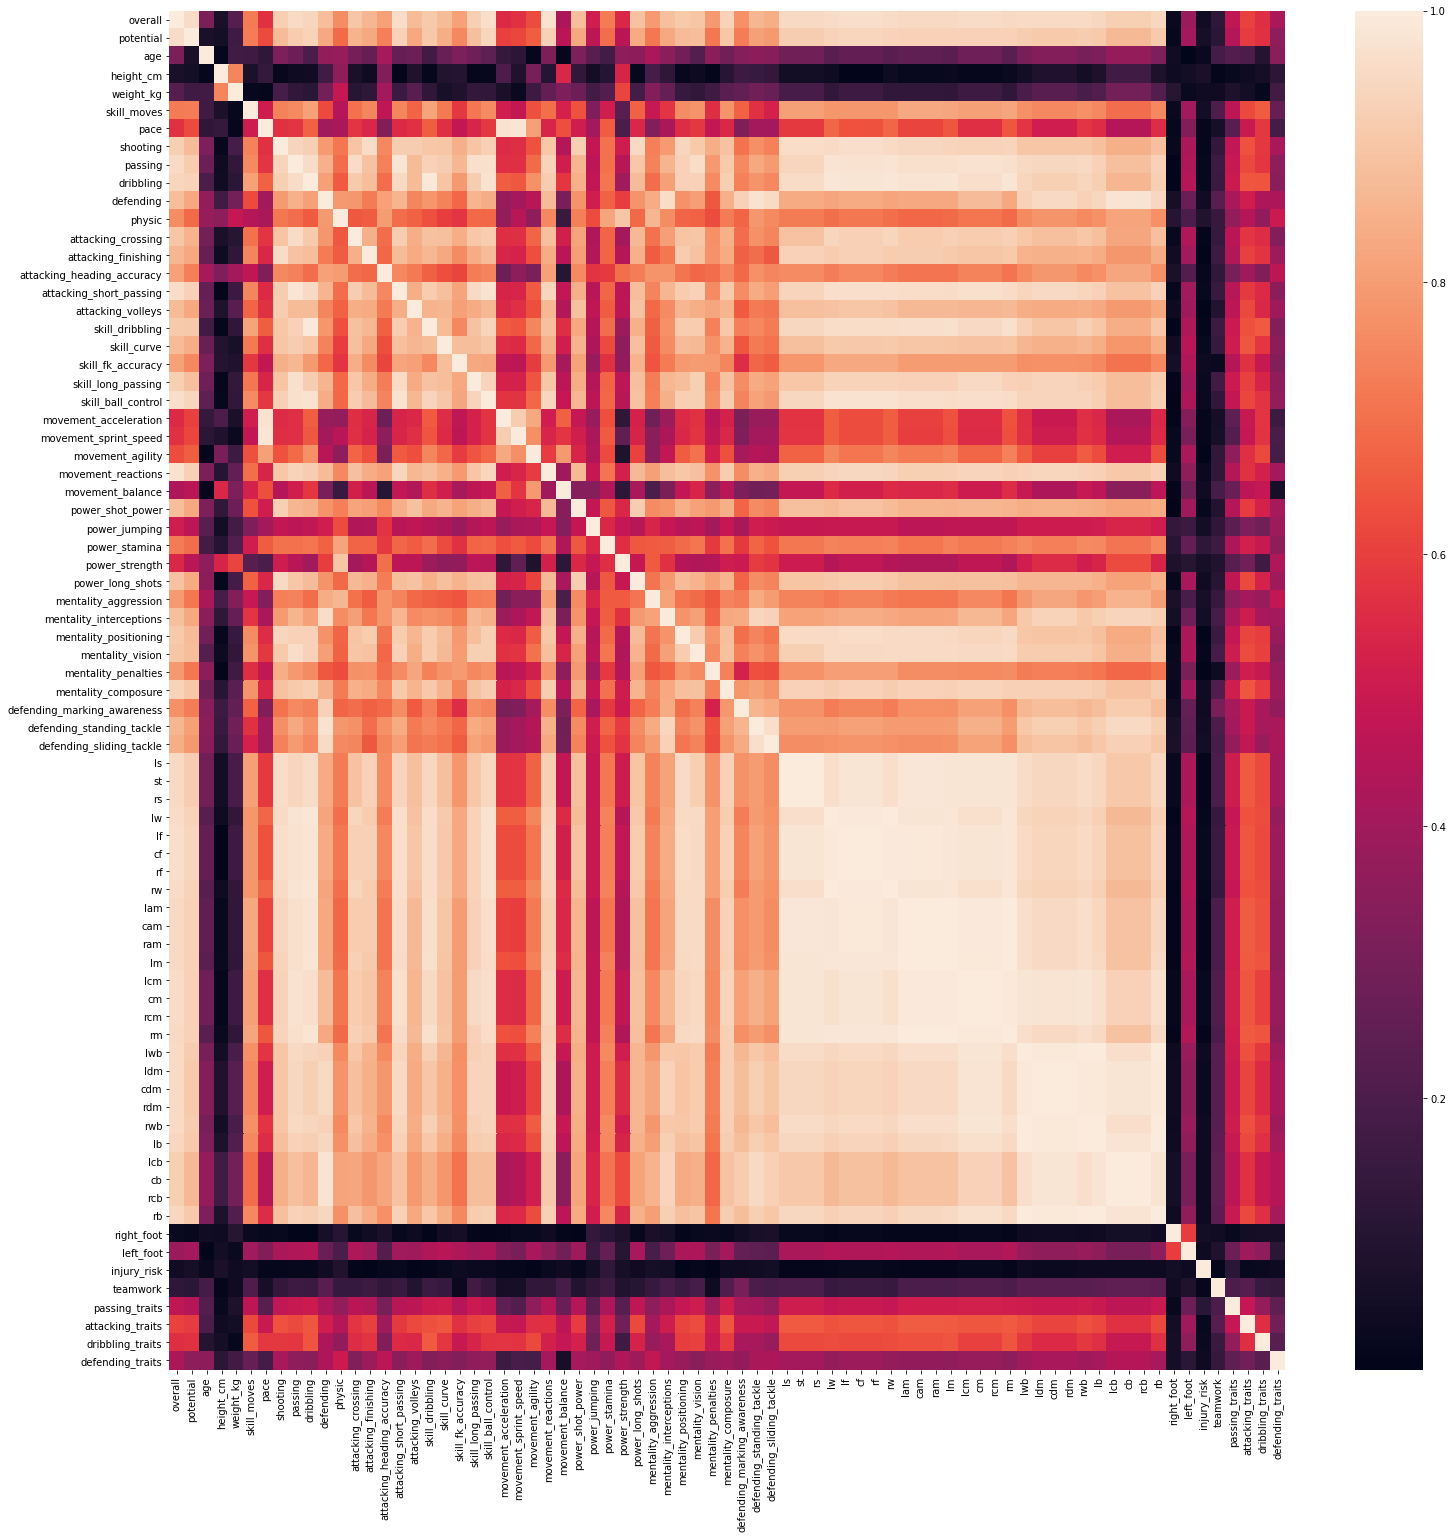

In [29]:
plt.figure(figsize = (25,25))
ax = sns.heatmap(abs(X_.corr()))

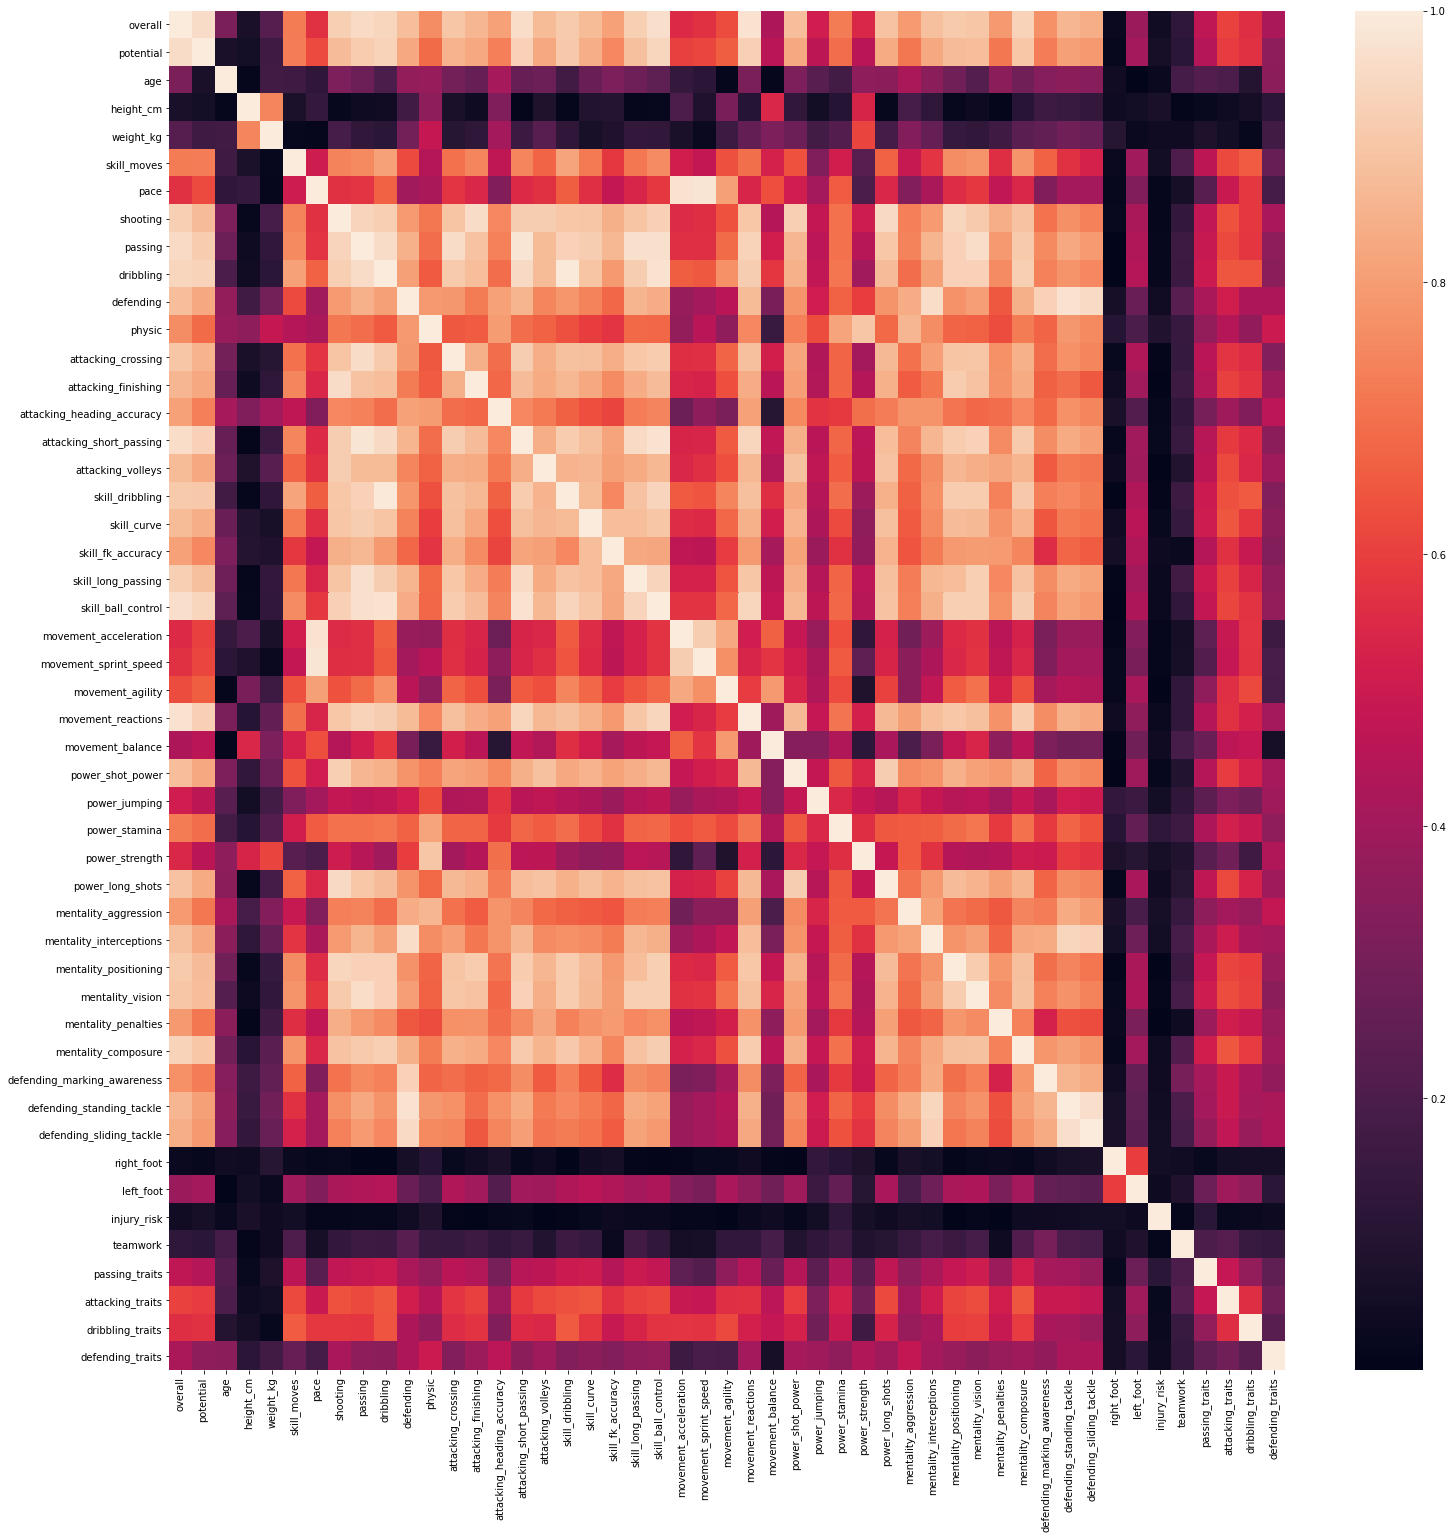

In [30]:
#There are many highly correlated features that can be dropped such as the features related to player position
correlated_drop = ['ls','st', 'rs', 'lw', 'lf', 'cf', 'rf', 'rw', 'lam', 'cam','ram', 'lm', 'lcm', 'cm', 'rcm', 'rm',
                   'lwb', 'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb']
X_2 = X_.drop(columns = correlated_drop)
plt.figure(figsize = (25,25))
ax = sns.heatmap(abs(X_2.corr()))

In [31]:
highly_correlated = X_2.corr()[(abs(X_2.corr()) > 0.8) & (abs(X_2.corr()) < 1)].count()[
X_2.corr()[(abs(X_2.corr()) > 0.8) & (abs(X_2.corr()) < 1)].count()> 5].sort_values(ascending=False)
highly_correlated

overall                      24
movement_reactions           24
skill_long_passing           23
attacking_short_passing      23
passing                      22
skill_ball_control           22
mentality_composure          21
dribbling                    21
potential                    21
power_long_shots             20
mentality_vision             20
attacking_volleys            20
attacking_crossing           20
shooting                     20
skill_dribbling              19
power_shot_power             19
skill_curve                  19
attacking_finishing          18
mentality_positioning        18
defending                    16
mentality_interceptions      16
defending_standing_tackle    13
skill_fk_accuracy            11
defending_sliding_tackle      9
mentality_aggression          6
dtype: int64

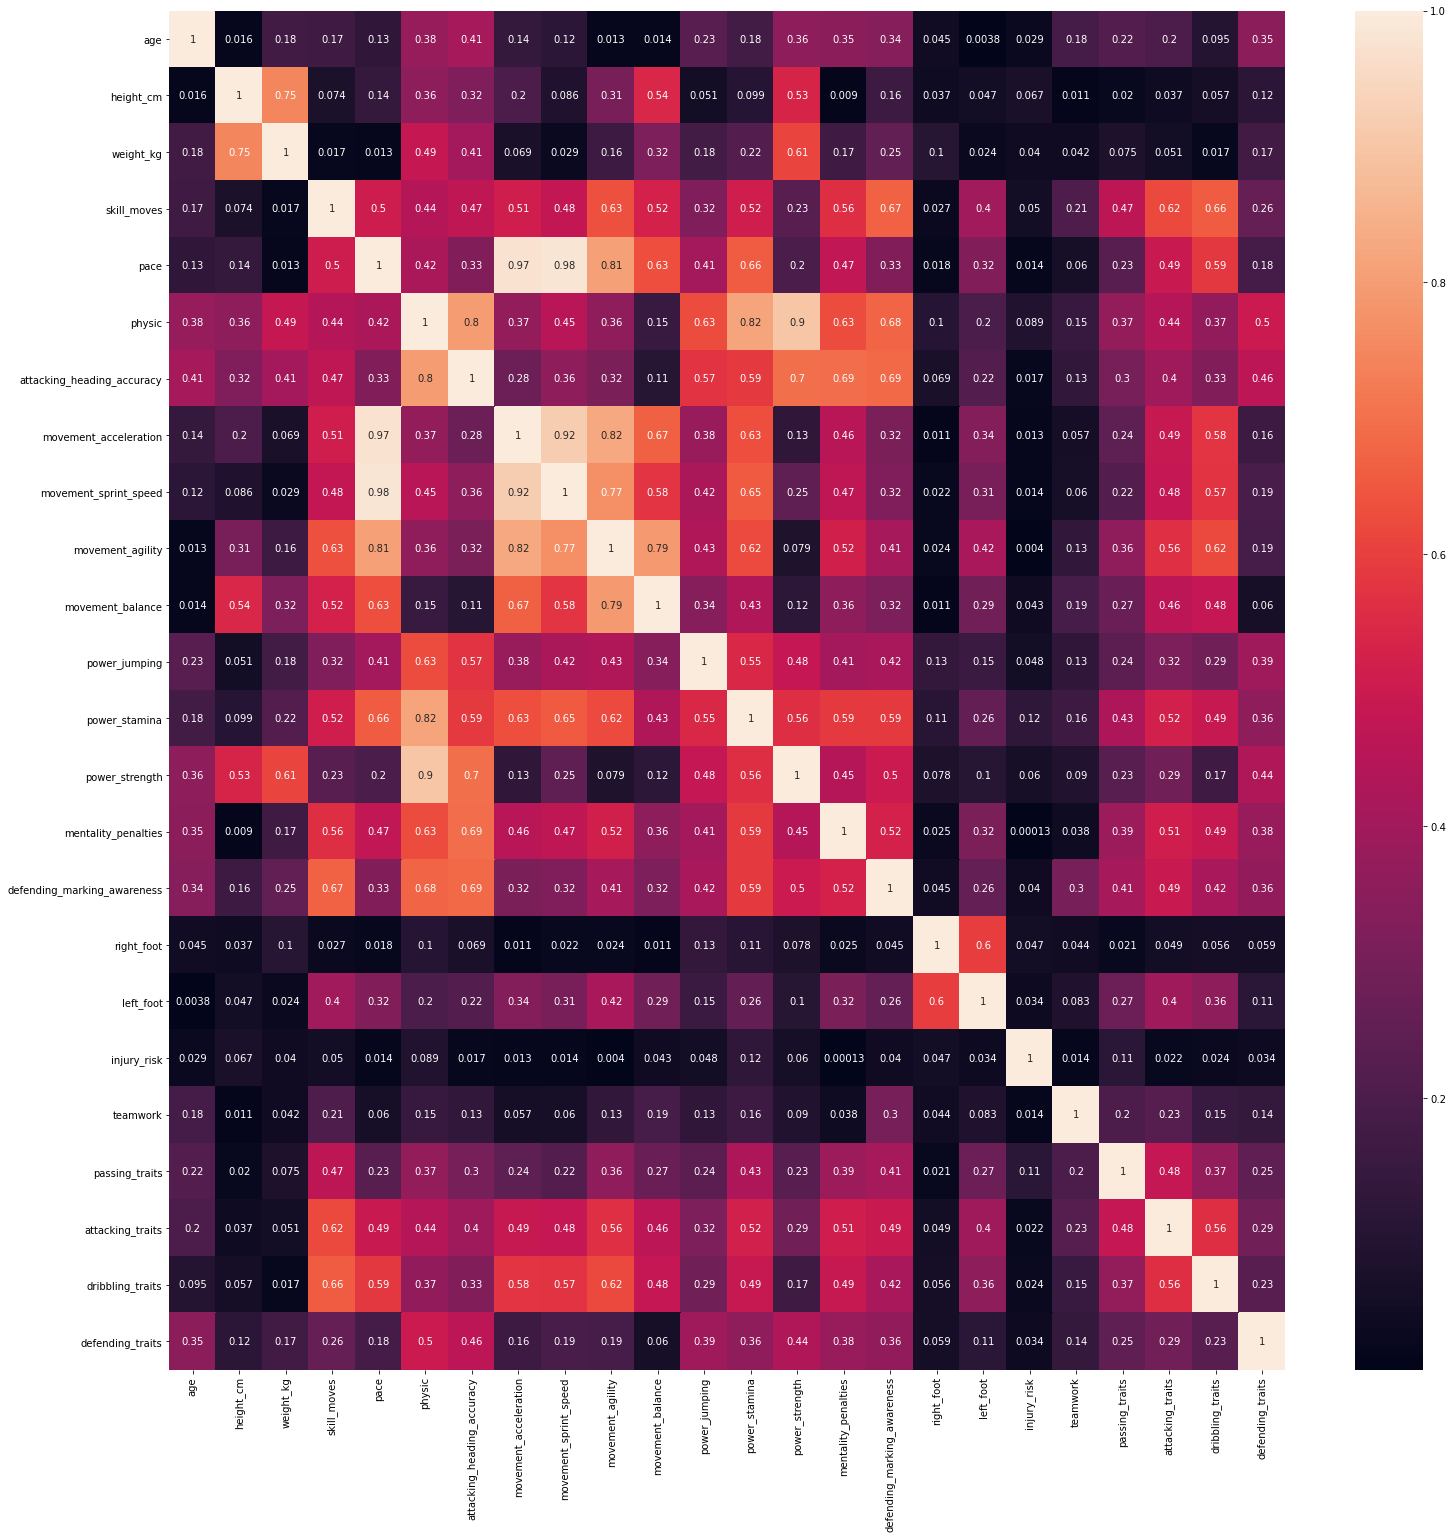

In [32]:
X_3 = X_2.drop(columns = highly_correlated.index)
plt.figure(figsize = (25,25))
ax = sns.heatmap(abs(X_3.corr()), annot=True)

In [33]:
X_3.corr()[(abs(X_3.corr()) > 0.8) & (abs(X_2.corr()) < 1)].count()[
X_3.corr()[(abs(X_3.corr()) > 0.8) & (abs(X_2.corr()) < 1)].count()>= 1].sort_values(ascending=False)

pace                          3
physic                        3
movement_acceleration         3
movement_sprint_speed         2
movement_agility              2
attacking_heading_accuracy    1
power_stamina                 1
power_strength                1
dtype: int64

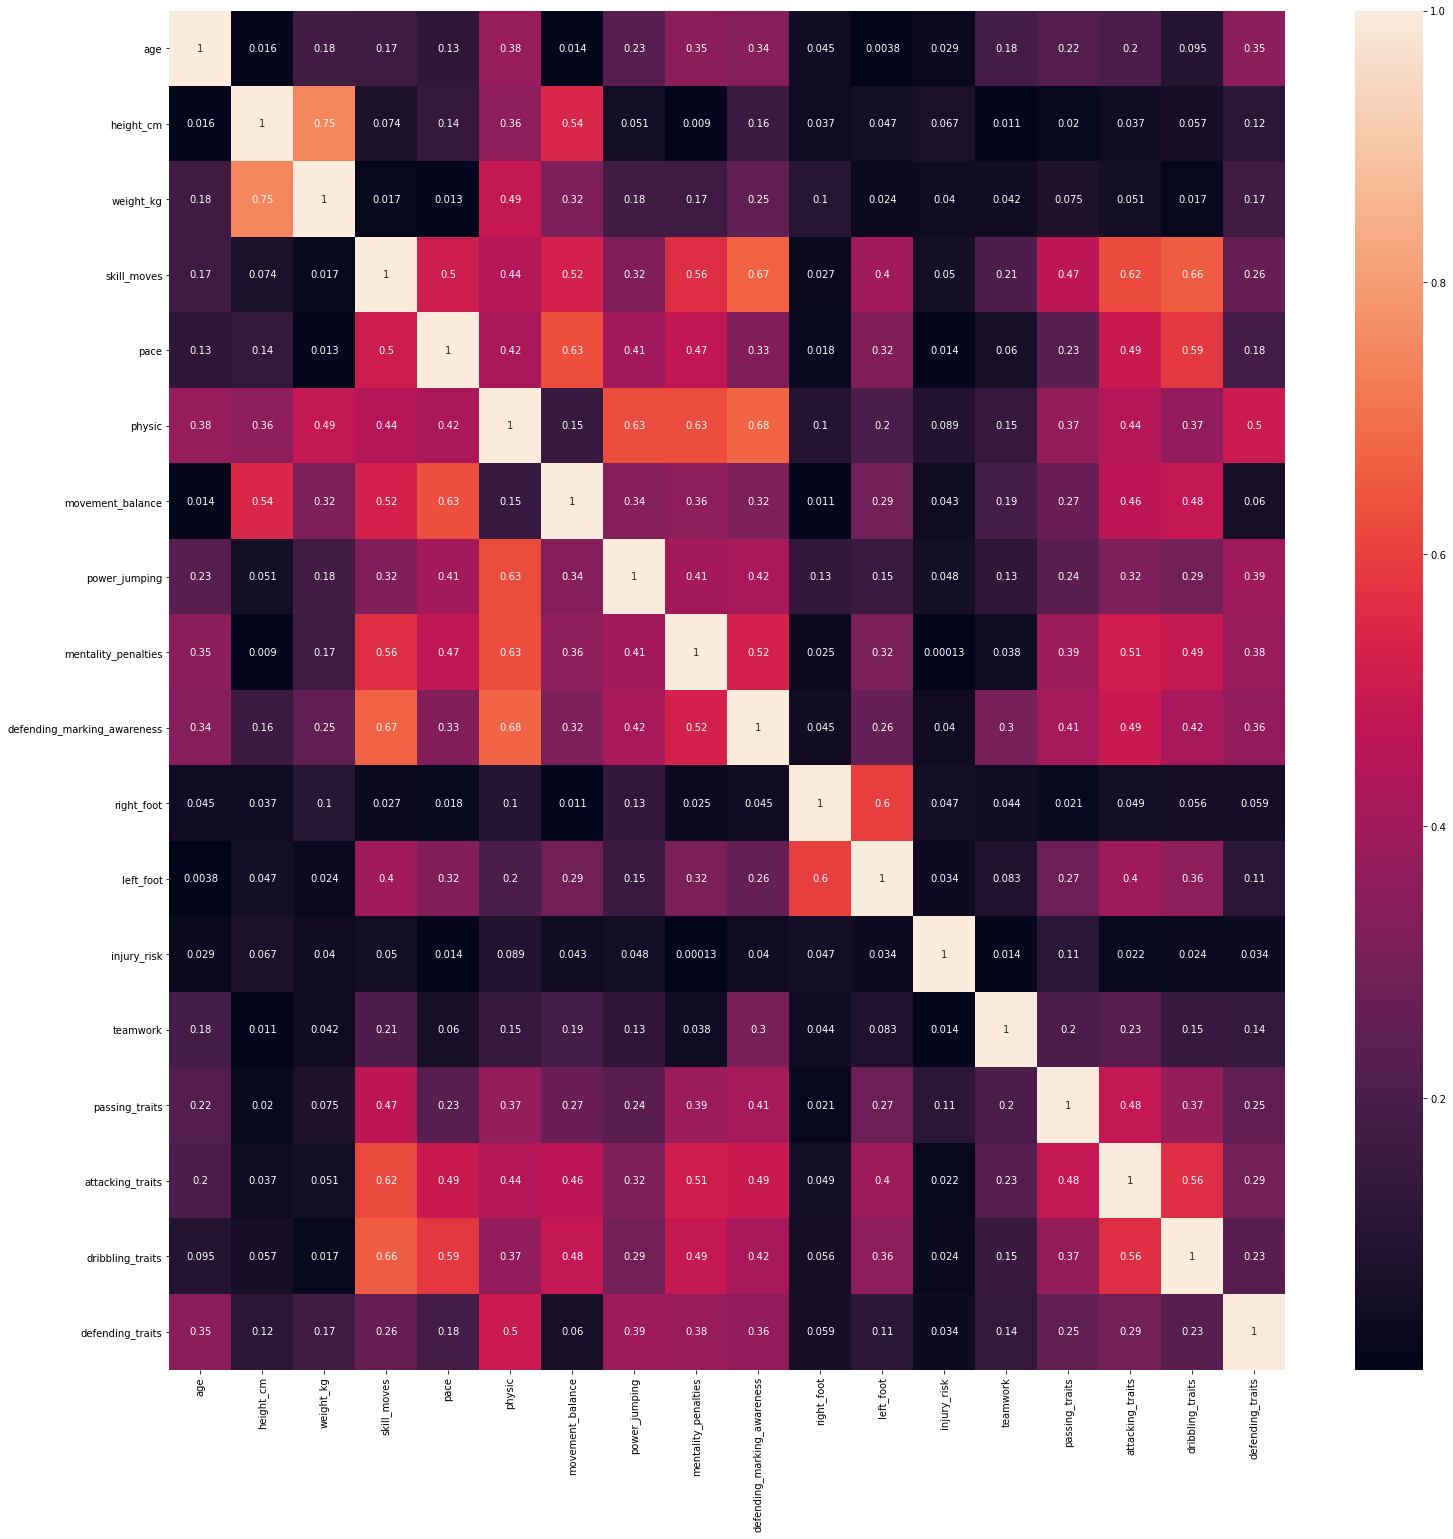

In [34]:
X = X_3.drop(columns = ['movement_acceleration', 'movement_sprint_speed', 'movement_agility',
                       'attacking_heading_accuracy', 'power_stamina', 'power_strength'])
plt.figure(figsize = (25,25))
ax = sns.heatmap(abs(X.corr()), annot=True)

In [35]:
X.columns

Index(['age', 'height_cm', 'weight_kg', 'skill_moves', 'pace', 'physic',
       'movement_balance', 'power_jumping', 'mentality_penalties',
       'defending_marking_awareness', 'right_foot', 'left_foot', 'injury_risk',
       'teamwork', 'passing_traits', 'attacking_traits', 'dribbling_traits',
       'defending_traits'],
      dtype='object')

In [36]:
print(len(y[y == 1]))
print(len(y[y==0]))

561
460


## Training/Testing Untuned Models

In [37]:
def train_test(classifier, X_data, y_data, i = 0, confusion_m=False):
    
    scaler = StandardScaler()
    
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42 + i)

    scores_df_test = pd.DataFrame(index=['recall', 'precision', 'accuracy', 'f1'])
    scores_df_train = pd.DataFrame(index=['recall', 'precision', 'accuracy', 'f1'])
    coefs_df = pd.DataFrame(index=list(X_data.columns))
    
    n_split = 1

    for train_index, test_index in skf.split(X_data, y_data):
        
        if str(classifier).split('(')[0] == 'LogisticRegression':
            X_train, X_test = scaler.fit_transform(X_data.iloc[train_index]), scaler.transform(X_data.iloc[test_index])
        else: 
            X_train, X_test = X_data.iloc[train_index], X_data.iloc[test_index]
        
        y_train, y_test = y_data.iloc[train_index], y_data.iloc[test_index]
            
        classifier.fit(X_train, y_train)
                                                     
        train_predictions = classifier.predict(X_train)
        test_predictions = classifier.predict(X_test)
                                                     
                                                     
        coefs = pd.DataFrame()
        coefs['names'] = list(X_data.columns)  
            
        if str(classifier).split('(')[0] != 'GaussianNB':
            if str(classifier).split('(')[0] == 'LogisticRegression':
                coefs_df[n_split] =  classifier.coef_.tolist()[0]
            else:
                coefs_df[n_split]  = classifier.feature_importances_.tolist()                                        
            

        scores_df_test[n_split] = [recall_score(y_test, test_predictions), precision_score(y_test, test_predictions),
                                   accuracy_score(y_test, test_predictions), f1_score(y_test, test_predictions)] 
        
        scores_df_train[n_split] = [recall_score(y_train, train_predictions), precision_score(y_train, train_predictions),
                                   accuracy_score(y_train, train_predictions), f1_score(y_train, train_predictions)] 
        
        if confusion_m:
            cm = confusion_matrix(y_test, test_predictions)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm,
            display_labels=clf.classes_)
            disp.plot();
        
        n_split +=1
        
    scores_df_test['mean_test'] = scores_df_test.mean(axis=1)
    scores_df_test['std_test'] = scores_df_test.std(axis=1)
    scores_df_train['mean_train'] = scores_df_train.mean(axis=1)
    scores_df_train['std_train'] = scores_df_train.std(axis=1)
  
    
    #display(scores_df_test, scores_df_train)
    
    return scores_df_test, scores_df_train, coefs_df    

In [38]:
#Primary test set results for Logistic untuned Model
train_test(LogisticRegression(random_state=42, max_iter=1000), X, y)[0]

,1,2,3,4,5,6,7,8,9,10,mean_test,std_test
recall,0.684211,0.732143,0.803571,0.696429,0.767857,0.803571,0.660714,0.678571,0.642857,0.678571,0.714850,0.055566
precision,0.750000,0.745455,0.775862,0.672414,0.741379,0.681818,0.672727,0.716981,0.666667,0.655172,0.707848,0.040819
accuracy,0.699029,0.715686,0.764706,0.647059,0.725490,0.686275,0.637255,0.676471,0.627451,0.627451,0.680687,0.044003
f1,0.715596,0.738739,0.789474,0.684211,0.754386,0.737705,0.666667,0.697248,0.654545,0.666667,0.710524,0.041913


In [39]:
#Primary train set results for Logistic untuned Model
train_test(LogisticRegression(random_state=42, max_iter=1000), X, y)[1].iloc[:, -2:]

,mean_train,std_train
recall,0.717172,0.006894
precision,0.711407,0.007545
accuracy,0.684731,0.007994
f1,0.714275,0.007085


In [40]:
#Primary test set results for GB untuned Model
train_test(GradientBoostingClassifier(random_state=42), X, y)[0]

,1,2,3,4,5,6,7,8,9,10,mean_test,std_test
recall,0.578947,0.678571,0.696429,0.660714,0.642857,0.714286,0.714286,0.732143,0.696429,0.553571,0.666823,0.056412
precision,0.717391,0.775510,0.735849,0.698113,0.800000,0.701754,0.655738,0.719298,0.722222,0.673913,0.719979,0.041000
accuracy,0.640777,0.715686,0.696078,0.656863,0.715686,0.676471,0.637255,0.696078,0.686275,0.607843,0.672901,0.034234
f1,0.640777,0.723810,0.715596,0.678899,0.712871,0.707965,0.683761,0.725664,0.709091,0.607843,0.690628,0.036894


In [41]:
#Primary train set results for GB untuned Model
#There is a lot of overfitting
train_test(GradientBoostingClassifier(random_state=42), X, y)[1]

,1,2,3,4,5,6,7,8,9,10,mean_train,std_train
recall,0.888889,0.871287,0.859406,0.867327,0.863366,0.883168,0.889109,0.867327,0.881188,0.877228,0.874829,0.010058
precision,0.916155,0.916667,0.935345,0.929936,0.925690,0.921488,0.916327,0.924051,0.917526,0.924843,0.922803,0.006129
accuracy,0.894336,0.885745,0.890098,0.891186,0.886834,0.894450,0.894450,0.887922,0.891186,0.893362,0.890957,0.003096
f1,0.902316,0.893401,0.895769,0.897541,0.893443,0.901921,0.902513,0.894791,0.898990,0.900407,0.898109,0.003441


In [42]:
#Primary test set results for GB untuned Model
train_test(GaussianNB(), X, y)[0]

,1,2,3,4,5,6,7,8,9,10,mean_test,std_test
recall,0.508772,0.535714,0.625000,0.535714,0.500000,0.571429,0.517857,0.625000,0.571429,0.553571,0.554449,0.041981
precision,0.725000,0.666667,0.795455,0.666667,0.800000,0.761905,0.690476,0.813953,0.680851,0.704545,0.730552,0.054699
accuracy,0.621359,0.598039,0.705882,0.598039,0.656863,0.666667,0.607843,0.715686,0.617647,0.627451,0.641548,0.040744
f1,0.597938,0.594059,0.700000,0.594059,0.615385,0.653061,0.591837,0.707071,0.621359,0.620000,0.629477,0.041018


In [43]:
train_test(GaussianNB(), X, y)[1]

,1,2,3,4,5,6,7,8,9,10,mean_train,std_train
recall,0.561508,0.574257,0.564356,0.564356,0.574257,0.558416,0.562376,0.570297,0.578218,0.560396,0.566844,0.006516
precision,0.744737,0.749354,0.732648,0.748031,0.732323,0.736292,0.749340,0.727273,0.737374,0.742782,0.740015,0.007517
accuracy,0.653595,0.660501,0.647443,0.656148,0.650707,0.647443,0.656148,0.646355,0.655060,0.651795,0.652519,0.004370
f1,0.640271,0.650224,0.637584,0.643341,0.643729,0.635135,0.642534,0.639290,0.648169,0.638826,0.641910,0.004447


## Hyperparameter Tuning - Bayesian Optimization

In [44]:
#Logistic Regression Tuning

params = dict()
params['clf__C'] = Real(1e-6, 1e+6, prior='log-uniform')
params['clf__solver'] = Categorical(['lbfgs', 'liblinear', 'newton-cg', 
                                     'newton-cholesky', 'sag', 'saga'])

scaler = StandardScaler()
clf = LogisticRegression(random_state=42, penalty='l2', max_iter=1000)

pipeline = Pipeline(steps=[("scaler", scaler), ("clf", clf)])

cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

search = BayesSearchCV(pipeline, search_spaces=params, n_jobs=-1, cv=cv, scoring='f1', 
                       random_state=42)


search.fit(X, y)

print(search.best_score_)
print(search.best_params_)

0.7129452877838822
OrderedDict([('clf__C', 0.21776603694820984), ('clf__solver', 'saga')])


In [45]:
#Test set results for tuned Logistic Model
train_test(LogisticRegression(random_state=42, max_iter=1000, penalty='l2',
                              solver='saga', C=0.21776603694820984), X, y)[0]

,1,2,3,4,5,6,7,8,9,10,mean_test,std_test
recall,0.684211,0.732143,0.803571,0.696429,0.767857,0.803571,0.660714,0.696429,0.642857,0.696429,0.718421,0.053661
precision,0.764706,0.745455,0.775862,0.672414,0.741379,0.681818,0.672727,0.722222,0.666667,0.650000,0.709325,0.043349
accuracy,0.708738,0.715686,0.764706,0.647059,0.725490,0.686275,0.637255,0.686275,0.627451,0.627451,0.682638,0.044484
f1,0.722222,0.738739,0.789474,0.684211,0.754386,0.737705,0.666667,0.709091,0.654545,0.672414,0.712945,0.041199


In [46]:
#Train set results for tuned Logistic Model
train_test(LogisticRegression(random_state=42, max_iter=1000, penalty='l2',
                              solver='saga', C=0.21776603694820984), X, y)[1]

,1,2,3,4,5,6,7,8,9,10,mean_train,std_train
recall,0.720238,0.708911,0.712871,0.722772,0.712871,0.716832,0.726733,0.708911,0.718812,0.724752,0.717370,0.006046
precision,0.707602,0.701961,0.696325,0.712891,0.708661,0.709804,0.721022,0.700587,0.720238,0.717647,0.709674,0.007999
accuracy,0.683007,0.674646,0.671382,0.687704,0.681175,0.683351,0.695321,0.673558,0.692057,0.692057,0.683426,0.007959
f1,0.713864,0.705419,0.704501,0.717797,0.710760,0.713300,0.723866,0.704724,0.719524,0.721182,0.713494,0.006725


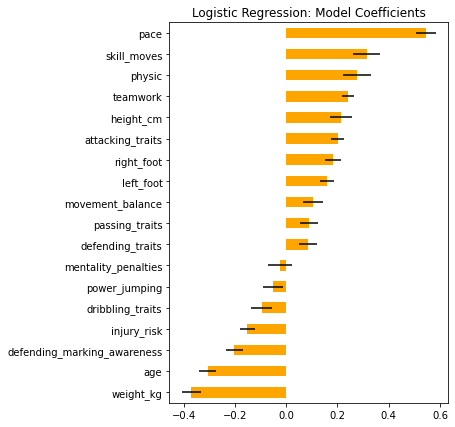

In [47]:
#plot_coefficients
#defending_marking_awareness looks unimportant
lr_coef = train_test(LogisticRegression(random_state=42, max_iter=1000, penalty='l2',solver='saga', 
                              C=0.21776603694820984), X, y)[2]
lr_coef['mean'] = lr_coef.mean(axis = 1)
lr_coef = lr_coef.sort_values(by = 'mean')
lr_coef['mean'].plot(kind='barh', title='Logistic Regression: Model Coefficients'
                     ,figsize=(5, 7), xerr=lr_coef.std(axis=1), color="orange"); 

#ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)

In [48]:
#Gradient Boosting Classifier Tuning
params = {
    'learning_rate': Real(1e-5, 1, prior = 'log-uniform'),
    'n_estimators': Integer(20, 1_500),
    'subsample': Real(0.05, 1),
    'max_depth': Integer(1, 5) }

clf = GradientBoostingClassifier(random_state=42)


cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

search = BayesSearchCV(clf, search_spaces=params, n_jobs=-1, cv=cv, scoring='f1',
                       random_state=42, verbose=1)


search.fit(X, y)

print(search.best_score_)
print(search.best_params_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for eac

In [49]:
#Test set results for tuned GB Model
#Results are comparable to the Logistic model, we will opt for logistic
train_test(GradientBoostingClassifier(random_state=42, learning_rate= 0.0004141137295814182,
                              max_depth=5,  n_estimators=1500, subsample= 0.05),
           X, y)[0]

,1,2,3,4,5,6,7,8,9,10,mean_test,std_test
recall,0.754386,0.785714,0.785714,0.767857,0.767857,0.892857,0.767857,0.803571,0.732143,0.750000,0.780796,0.042000
precision,0.716667,0.698413,0.698413,0.641791,0.728814,0.675676,0.651515,0.703125,0.640625,0.646154,0.680119,0.031505
accuracy,0.699029,0.696078,0.696078,0.637255,0.715686,0.705882,0.647059,0.705882,0.627451,0.637255,0.676766,0.032998
f1,0.735043,0.739496,0.739496,0.699187,0.747826,0.769231,0.704918,0.750000,0.683333,0.694215,0.726274,0.027131


In [50]:
#Train set results for tuned GB Model
#Overfitting is much better 
train_test(GradientBoostingClassifier(random_state=42, learning_rate= 0.0004141137295814182,
                              max_depth=5,  n_estimators=1500, subsample= 0.05),
           X, y)[1]

,1,2,3,4,5,6,7,8,9,10,mean_train,std_train
recall,0.825397,0.827723,0.821782,0.823762,0.821782,0.827723,0.823762,0.839604,0.825743,0.835644,0.827292,0.005598
precision,0.723478,0.713311,0.710616,0.708688,0.716753,0.715753,0.722222,0.710218,0.711604,0.725086,0.715773,0.005655
accuracy,0.730937,0.722524,0.718172,0.717084,0.723613,0.724701,0.729053,0.723613,0.720348,0.735582,0.724563,0.005502
f1,0.771084,0.766269,0.762167,0.761905,0.765683,0.767677,0.769658,0.769510,0.764436,0.776449,0.767484,0.004191


In [53]:
#Naive Bayes Classifier Tuning
params = {'var_smoothing': Real(1e-15, 1e-1, prior = 'log-uniform')}

clf = GaussianNB()

cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

search = BayesSearchCV(clf, search_spaces=params, n_jobs=-1, cv=cv, scoring='f1',
                       random_state=42, verbose=1)

search.fit(X, y)

print(search.best_score_)
print(search.best_params_)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


The objective has been evaluated at this point before.


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


The objective has been evaluated at this point before.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


The objective has been evaluated at this point before.


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


The objective has been evaluated at this point before.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


The objective has been evaluated at this point before.


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


The objective has been evaluated at this point before.


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


The objective has been evaluated at this point before.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


The objective has been evaluated at this point before.


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


The objective has been evaluated at this point before.


Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits
Fitting 10 folds for each of 1 candidates, totalling 10 fits


The objective has been evaluated at this point before.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


The objective has been evaluated at this point before.


Fitting 10 folds for each of 1 candidates, totalling 10 fits


The objective has been evaluated at this point before.


Fitting 10 folds for each of 1 candidates, totalling 10 fits
0.6491755332772642
OrderedDict([('var_smoothing', 0.015598913960122762)])


In [54]:
#Test set results for tuned Naive Bayes Classifier
train_test(GaussianNB(var_smoothing = 0.015598913960122762), X, y)[0]

,1,2,3,4,5,6,7,8,9,10,mean_test,std_test
recall,0.561404,0.607143,0.660714,0.517857,0.517857,0.642857,0.535714,0.660714,0.625000,0.571429,0.590069,0.053696
precision,0.744186,0.708333,0.740000,0.630435,0.763158,0.720000,0.652174,0.840909,0.714286,0.727273,0.724075,0.054904
accuracy,0.650485,0.647059,0.686275,0.568627,0.647059,0.666667,0.588235,0.745098,0.656863,0.647059,0.650343,0.045984
f1,0.640000,0.653846,0.698113,0.568627,0.617021,0.679245,0.588235,0.740000,0.666667,0.640000,0.649176,0.048249


In [55]:
train_test(GaussianNB(var_smoothing = 0.015598913960122762), X, y)[1]

,1,2,3,4,5,6,7,8,9,10,mean_train,std_train
recall,0.593254,0.590099,0.590099,0.600000,0.594059,0.594059,0.601980,0.596040,0.598020,0.598020,0.595563,0.003778
precision,0.727494,0.732187,0.728606,0.737226,0.729927,0.728155,0.739659,0.716667,0.733010,0.736585,0.730952,0.006189
accuracy,0.654684,0.656148,0.653972,0.662677,0.656148,0.655060,0.664853,0.648531,0.659412,0.661589,0.657307,0.004597
f1,0.653552,0.653509,0.652079,0.661572,0.655022,0.654308,0.663755,0.650811,0.658670,0.660109,0.656339,0.004152


## Best Classifier

In [56]:
best_clf = LogisticRegression(random_state=42, max_iter=1000, penalty='l2',solver='saga', 
                              C=0.21776603694820984)

## Feature Analysis

In [104]:
from tqdm import tqdm

feature_importance_logistic = pd.DataFrame()
d = collections.defaultdict(list)
all_feats = list(X.columns)
clf = LogisticRegression(random_state=42, max_iter=1000, penalty='l2',solver='saga', 
                              C=0.21776603694820984)

for i in tqdm(range(20)):
    ground_truth = np.array(train_test(clf, X, y, i=i)[0].iloc[2, -1])
    
    for e in list(X.columns):
        removed_1 = [i for i in all_feats if i != e]
        X_removed = X[removed_1].copy()
        d[e].append(ground_truth - np.array(train_test(clf, X_removed, y, i=i)[0].iloc[2, -1])) 

for e in list(X.columns):
    feature_importance_logistic[e] = d[e]

100%|██████████| 20/20 [01:41<00:00,  5.05s/it]


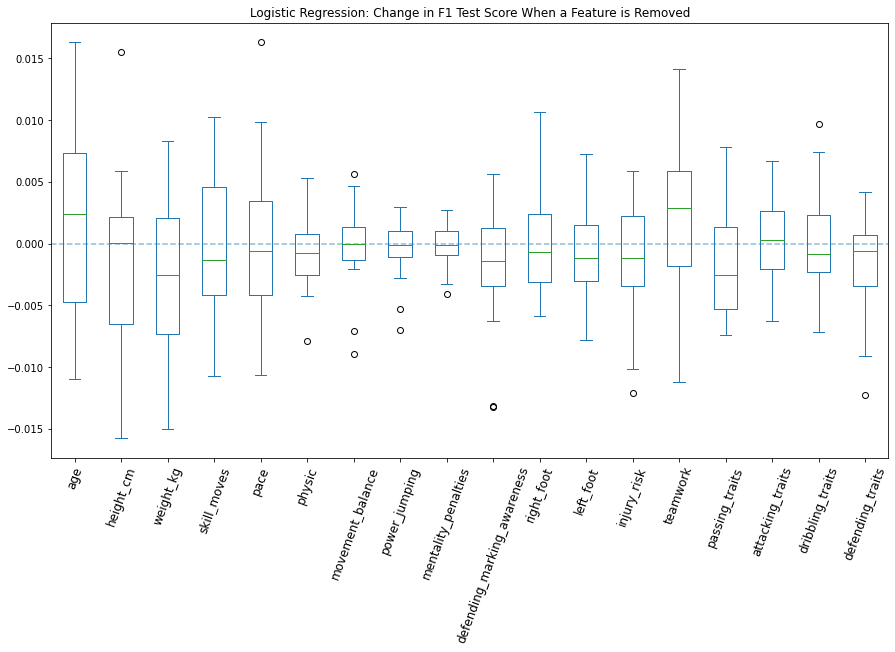

In [106]:
feature_importance_logistic.plot(kind='box', figsize=(15, 8))
plt.xticks(rotation=90)
plt.axhline(0, ls='--', alpha=0.5)
plt.xticks(rotation=70, fontsize=12)
plt.title('Logistic Regression: Change in F1 Test Score When a Feature is Removed')
plt.show();

In [59]:
#Do results improve when we remove features that are negatively influence the F1 score?
train_test(best_clf, X.drop(columns= ['mentality_penalties']), y)[0]

,1,2,3,4,5,6,7,8,9,10,mean_test,std_test
recall,0.684211,0.732143,0.803571,0.714286,0.767857,0.803571,0.642857,0.696429,0.642857,0.696429,0.718421,0.055415
precision,0.764706,0.759259,0.775862,0.677966,0.728814,0.681818,0.666667,0.722222,0.666667,0.650000,0.709398,0.044083
accuracy,0.708738,0.725490,0.764706,0.656863,0.715686,0.686275,0.627451,0.686275,0.627451,0.627451,0.682638,0.044914
f1,0.722222,0.745455,0.789474,0.695652,0.747826,0.737705,0.654545,0.709091,0.654545,0.672414,0.712893,0.041961


## Learning Curve

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,
    random_state=42, shuffle=True, stratify=y)

In [62]:
size_list = [100, 200, 300, 400, 500, 600, 700, 800, 900]

mean_list = []
std_list = []

for size in size_list:
    score_list = []
    for i in range(10):
        new_X = X_train.sample(size, replace=False)
        new_Y = y_train.sample(size, replace=False)
        
        # FIT
        scaler = StandardScaler()
        new_X_scaled = scaler.fit_transform(new_X)
        scaled_X_test = scaler.transform(X_test)
        
        best_clf.fit(new_X_scaled, new_Y)
        
        score = f1_score(best_clf.predict(scaled_X_test), y_test)
        
        score_list.append(score)
        
    mean_list.append(np.mean(score_list))
    std_list.append(np.std(score_list))

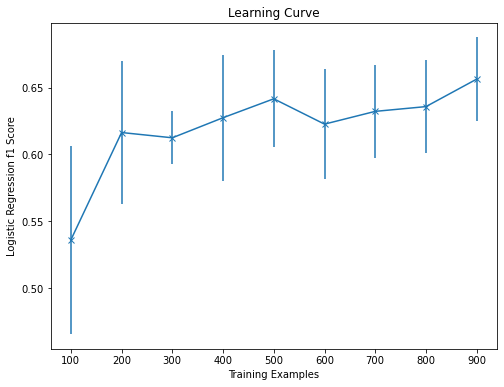

In [63]:
#Adding more examples reduces error and increases model performance
plt.figure(figsize=(8, 6))
plt.errorbar(size_list, mean_list, std_list, linestyle='-', marker='x')
plt.ylabel('Logistic Regression f1 Score')
plt.xlabel('Training Examples')
plt.title('Learning Curve');

## Sensitivity Analysis 

In [69]:
test_f1 = []
std_f1 = []

C_values = np.linspace(0.011, 100, 500)
for e in tqdm(C_values):
    trained_rf = train_test(LogisticRegression(random_state=42, C=e, penalty='l2', 
                                               max_iter=1000, solver = 'saga'), X, y)
    test_f1.append(trained_rf[0].iloc[:, -2][-1])
    std_f1.append(trained_rf[0].iloc[:, -1][-1])

100%|██████████| 500/500 [03:26<00:00,  2.42it/s]


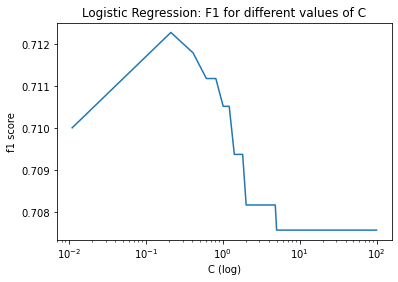

In [70]:
plt.plot(C_values, test_f1)
#plt.fill_between(C_values, np.array(test_f1) - np.array(std_f1) , 
                 #np.array(test_f1) + np.array(std_f1),alpha=.1)

plt.xscale("log")
plt.xlabel("C (log)")
plt.ylabel("f1 score")
plt.title('Logistic Regression: F1 for different values of C');

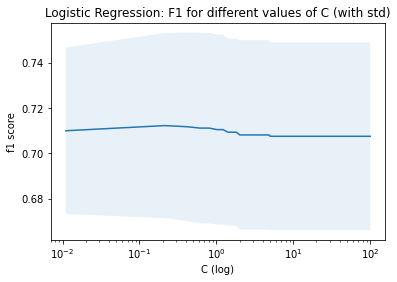

In [71]:
plt.plot(C_values, test_f1)
plt.fill_between(C_values, np.array(test_f1) - np.array(std_f1) , 
                 np.array(test_f1) + np.array(std_f1),alpha=.1)

plt.xscale("log")
plt.xlabel("C (log)")
plt.ylabel("f1 score")
plt.title('Logistic Regression: F1 for different values of C (with std)');

In [72]:
test_f1_s = {}
std_f1_s = {}

solver = ['lbfgs' , 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']

for s in solver:
    f1_list = []
    std_list = []
    for e in tqdm(C_values):
        trained_rf = train_test(LogisticRegression(random_state=42, C=e, penalty='l2', 
                                                   max_iter=1000, solver = s), X, y)
        f1_list.append(trained_rf[0].iloc[:, -2][-1])
        std_list.append(trained_rf[0].iloc[:, -1][-1])
    test_f1_s[s] = f1_list
    std_f1_s[s] = std_list    

100%|██████████| 500/500 [02:20<00:00,  3.55it/s]


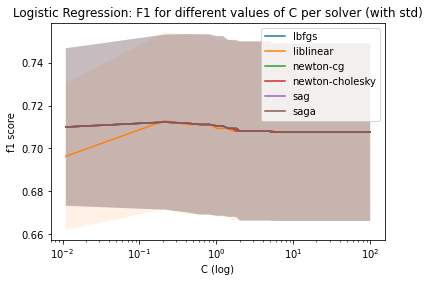

In [73]:
plt.plot(C_values, test_f1_s['lbfgs'], label = 'lbfgs')
plt.plot(C_values, test_f1_s['liblinear'], label = 'liblinear')
plt.plot(C_values, test_f1_s['newton-cg'], label = 'newton-cg' )
plt.plot(C_values, test_f1_s['newton-cholesky'], label = 'newton-cholesky' )
plt.plot(C_values, test_f1_s['sag'], label = 'sag')
plt.plot(C_values, test_f1_s['saga'], label = 'saga')
plt.legend()

plt.fill_between(C_values, np.array(test_f1_s['lbfgs']) - np.array(std_f1_s['lbfgs']) , 
                 np.array(test_f1_s['lbfgs']) + np.array(std_f1_s['lbfgs']),alpha=.1)
plt.fill_between(C_values, np.array(test_f1_s['liblinear']) - np.array(std_f1_s['liblinear']) , 
                 np.array(test_f1_s['liblinear']) + np.array(std_f1_s['liblinear']),alpha=.1)
plt.fill_between(C_values, np.array(test_f1_s['newton-cg']) - np.array(std_f1_s['newton-cg']) , 
                 np.array(test_f1_s['newton-cg']) + np.array(std_f1_s['newton-cg']),alpha=.1)
plt.fill_between(C_values, np.array(test_f1_s['newton-cg']) - np.array(std_f1_s['newton-cg']) , 
                 np.array(test_f1_s['newton-cholesky']) + np.array(std_f1_s['newton-cholesky']),alpha=.1)
plt.fill_between(C_values, np.array(test_f1_s['sag']) - np.array(std_f1_s['sag']) , 
                 np.array(test_f1_s['sag']) + np.array(std_f1_s['sag']),alpha=.1)
plt.fill_between(C_values, np.array(test_f1_s['saga']) - np.array(std_f1_s['saga']) , 
                 np.array(test_f1_s['saga']) + np.array(std_f1_s['saga']),alpha=.1)


plt.xscale("log")
plt.xlabel("C (log)")
plt.ylabel("f1 score")
plt.title('Logistic Regression: F1 for different values of C per solver (with std)');

In [74]:
scaler = StandardScaler()
    
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


n_split = 1

classifier = LogisticRegression(random_state=42, max_iter=1000, penalty='l2',solver='saga', 
                              C=0.21776603694820984)


thresholds = np.linspace(0.01, 0.99, 200)

recall_df = pd.DataFrame(index=thresholds.tolist())
precision_df = pd.DataFrame(index=thresholds.tolist())
f1_df = pd.DataFrame(index=thresholds.tolist())

for train_index, test_index in skf.split(X, y):

    X_train, X_test = scaler.fit_transform(X.iloc[train_index]), scaler.transform(X.iloc[test_index])


    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    classifier.fit(X_train, y_train)

    test_predictions = classifier.predict_proba(X_test).T[1]

    recall = []
    precision = []
    f1 = []


    for threshold in thresholds:
        temp = (test_predictions >= threshold).astype(int)

        recall.append(recall_score(y_test, temp))
        precision.append(precision_score(y_test, temp, zero_division=1))
        f1.append(f1_score(y_test, temp, zero_division=1))
                 
        
    recall_df[n_split] = recall
    precision_df[n_split] = precision
    f1_df[n_split] = f1

    n_split +=1

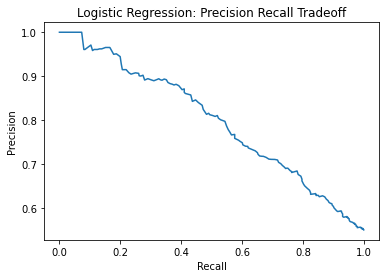

In [75]:
plt.plot(recall_df.mean(axis=1), precision_df.mean(axis=1))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Logistic Regression: Precision Recall Tradeoff');

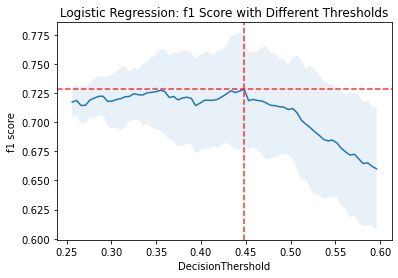

In [76]:
plt.plot(list(f1_df.index)[50:120], list(f1_df.mean(axis=1))[50:120])
plt.axhline( 0.7280210592157946, ls='--', color='r', alpha=0.8)
plt.axvline( 0.448291, ls='--', color='r', alpha = 0.8)
plt.fill_between(list(f1_df.index)[50:120], np.array(f1_df.mean(axis=1))[50:120] - np.array(f1_df.std(axis=1))[50:120] , 
                 np.array(f1_df.mean(axis=1))[50:120] + np.array(f1_df.std(axis=1))[50:120],alpha=.1)
plt.title('Logistic Regression: f1 Score with Different Thresholds')
plt.xlabel('DecisionThershold')
plt.ylabel('f1 score');


In [77]:
f1_df.mean(axis=1).max()

0.7280210592157946

## Failure Analysis

,1,2,3,4,5,6,7,8,9,10,mean_test,std_test
recall,0.684211,0.732143,0.803571,0.696429,0.767857,0.803571,0.660714,0.696429,0.642857,0.696429,0.718421,0.053661
precision,0.764706,0.745455,0.775862,0.672414,0.741379,0.681818,0.672727,0.722222,0.666667,0.650000,0.709325,0.043349
accuracy,0.708738,0.715686,0.764706,0.647059,0.725490,0.686275,0.637255,0.686275,0.627451,0.627451,0.682638,0.044484
f1,0.722222,0.738739,0.789474,0.684211,0.754386,0.737705,0.666667,0.709091,0.654545,0.672414,0.712945,0.041199


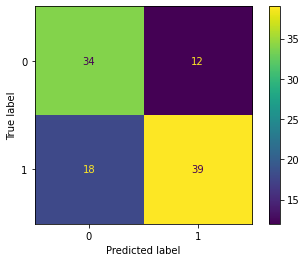

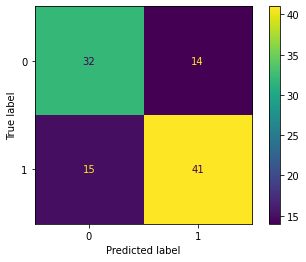

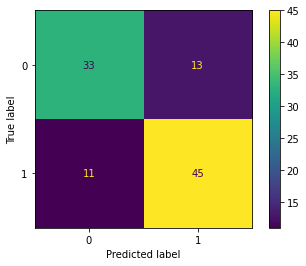

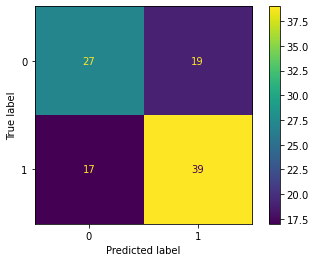

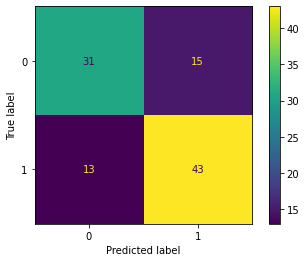

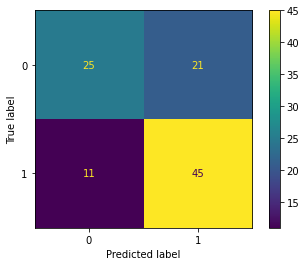

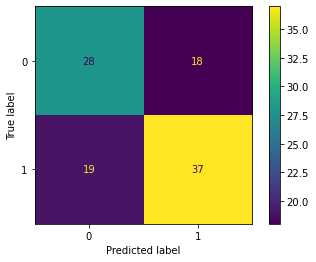

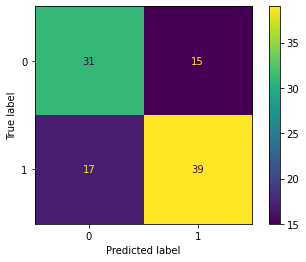

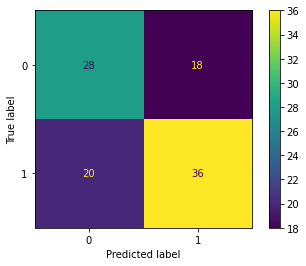

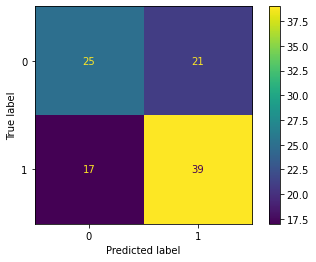

In [107]:
train_test(clf, X, y, i = 0, confusion_m=True)[0]

In [114]:
train_i = []
test_i = []
for train_index, test_index in skf.split(X, y):
    train_i.append(train_index)
    test_i.append(test_index)

In [161]:
X_train, X_test = scaler.fit_transform(X.iloc[train_i[8]]), scaler.transform(X.iloc[test_i[8]])

y_train, y_test = y.iloc[train_i[8]], y.iloc[test_i[8]]

classifier.fit(X_train, y_train)

test_predictions = classifier.predict_proba(X_test)

explainer = shap.Explainer(classifier.predict, X_test)

shap_values = explainer(pd.DataFrame(X_test, columns=X.columns))

[e for e in list(zip(test_predictions[:, -1], y_test, test_i[8], list(range(0, 103)))) if e[1] ==0]

[(0.43557977287011124, 0, 29, 0),
 (0.4025355081475869, 0, 30, 1),
 (0.2703656948332773, 0, 78, 2),
 (0.5123344802164721, 0, 79, 3),
 (0.7037188533054533, 0, 96, 4),
 (0.2825469662837, 0, 111, 6),
 (0.730489544579583, 0, 146, 8),
 (0.22458599977827767, 0, 162, 10),
 (0.2759050833890681, 0, 165, 11),
 (0.796362280747961, 0, 177, 12),
 (0.41984448519960466, 0, 197, 13),
 (0.8403729247893026, 0, 269, 19),
 (0.3158291151596396, 0, 340, 24),
 (0.4091646127076163, 0, 345, 25),
 (0.3031750912231132, 0, 382, 30),
 (0.1967766498516384, 0, 395, 32),
 (0.4833911698787134, 0, 412, 34),
 (0.8524443194122703, 0, 429, 36),
 (0.27019932201769165, 0, 433, 37),
 (0.20405857837932992, 0, 434, 38),
 (0.31943257990131935, 0, 448, 40),
 (0.27565410822631303, 0, 449, 41),
 (0.2173565091418452, 0, 493, 42),
 (0.7695484125212332, 0, 528, 44),
 (0.8679723244673226, 0, 555, 45),
 (0.41006924225921776, 0, 569, 47),
 (0.5590950845227226, 0, 591, 50),
 (0.6229455397129523, 0, 592, 51),
 (0.2546435666505899, 0, 593,

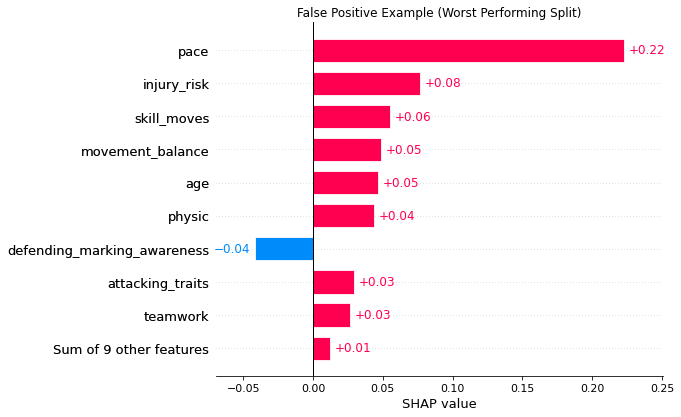

In [158]:
shap.plots.bar(shap_values[45], show=False)
plt.title("False Positive Example (Worst Performing Split)");

In [162]:
X.iloc[555]

age                             25.20
height_cm                      181.10
weight_kg                       76.45
skill_moves                      2.90
pace                            72.00
physic                          71.30
movement_balance                71.00
power_jumping                   73.55
mentality_penalties             58.00
defending_marking_awareness     62.90
right_foot                       4.35
left_foot                        3.85
injury_risk                     -0.20
teamwork                         0.10
passing_traits                   0.20
attacking_traits                 0.35
dribbling_traits                 0.05
defending_traits                 0.20
Name: 605, dtype: float64

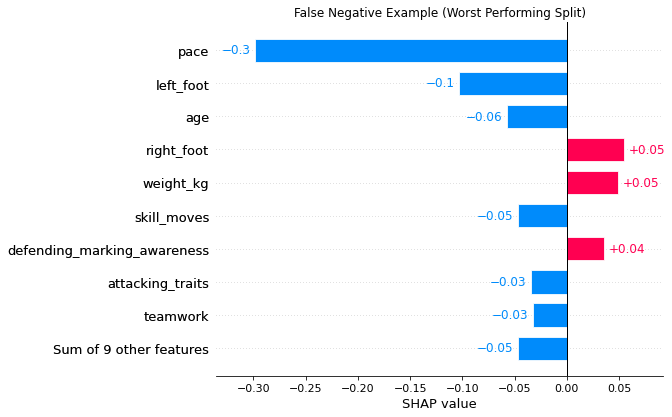

In [163]:
shap.plots.bar(shap_values[83], show=False)
plt.title("False Negative Example (Worst Performing Split)");

In [139]:
X.iloc[881]

age                             26.95
height_cm                      181.85
weight_kg                       73.90
skill_moves                      2.60
pace                            64.20
physic                          67.15
movement_balance                64.65
power_jumping                   66.40
mentality_penalties             57.15
defending_marking_awareness     50.45
right_foot                       4.75
left_foot                        3.15
injury_risk                      0.00
teamwork                         0.00
passing_traits                   0.00
attacking_traits                 0.05
dribbling_traits                 0.25
defending_traits                 0.15
Name: 990, dtype: float64

In [152]:
X_train, X_test = scaler.fit_transform(X.iloc[train_i[2]]), scaler.transform(X.iloc[test_i[2]])

y_train, y_test = y.iloc[train_i[2]], y.iloc[test_i[2]]

clf.fit(X_train, y_train)

test_predictions = classifier.predict_proba(X_test)

explainer = shap.Explainer(classifier.predict, X_test)

shap_values = explainer(pd.DataFrame(X_test, columns=X.columns))
[e for e in list(zip(test_predictions[:, -1], y_test, test_i[2], list(range(0, 103))))]

[(0.7399410012784617, 1, 5, 0),
 (0.3973789246447784, 0, 14, 1),
 (0.47417822121143377, 0, 15, 2),
 (0.26670424335906373, 0, 17, 3),
 (0.8513762006365255, 1, 20, 4),
 (0.2924708904703069, 1, 25, 5),
 (0.514585673152394, 1, 26, 6),
 (0.2054536266127913, 0, 33, 7),
 (0.400524928049653, 0, 50, 8),
 (0.6822469120032654, 1, 59, 9),
 (0.2857431558342353, 0, 66, 10),
 (0.4633689841130395, 1, 73, 11),
 (0.46320396621120263, 1, 74, 12),
 (0.17766112092073594, 0, 76, 13),
 (0.601769457933497, 1, 104, 14),
 (0.5048830328147194, 0, 114, 15),
 (0.7593517918090437, 1, 137, 16),
 (0.5811284114698182, 1, 144, 17),
 (0.7732731788864577, 1, 152, 18),
 (0.5937060987359799, 1, 155, 19),
 (0.8594096893868147, 1, 169, 20),
 (0.597931239549387, 1, 188, 21),
 (0.22969035756761108, 0, 202, 22),
 (0.41938967816978073, 0, 219, 23),
 (0.4612998299924576, 1, 228, 24),
 (0.30181716346495857, 0, 238, 25),
 (0.472314249344538, 0, 247, 26),
 (0.5868582676483862, 0, 251, 27),
 (0.42144562123324825, 0, 265, 28),
 (0.537

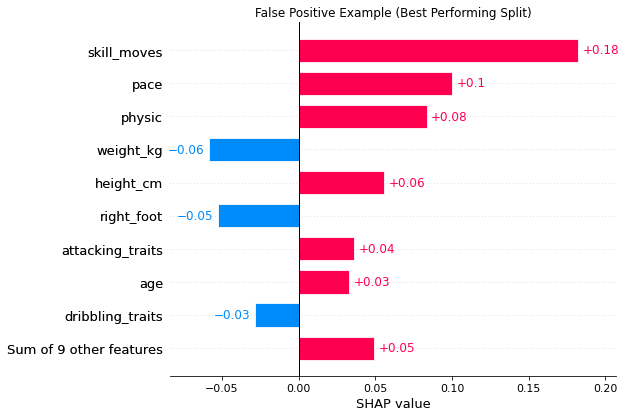

In [153]:
shap.plots.bar(shap_values[61], show=False)
plt.title("False Positive Example (Best Performing Split)");

In [156]:
X.iloc[573]

age                             25.45
height_cm                      182.70
weight_kg                       76.80
skill_moves                      3.00
pace                            70.70
physic                          71.60
movement_balance                66.30
power_jumping                   67.40
mentality_penalties             54.15
defending_marking_awareness     57.45
right_foot                       4.25
left_foot                        3.75
injury_risk                     -0.05
teamwork                         0.05
passing_traits                   0.35
attacking_traits                 0.40
dribbling_traits                 0.30
defending_traits                 0.15
Name: 623, dtype: float64

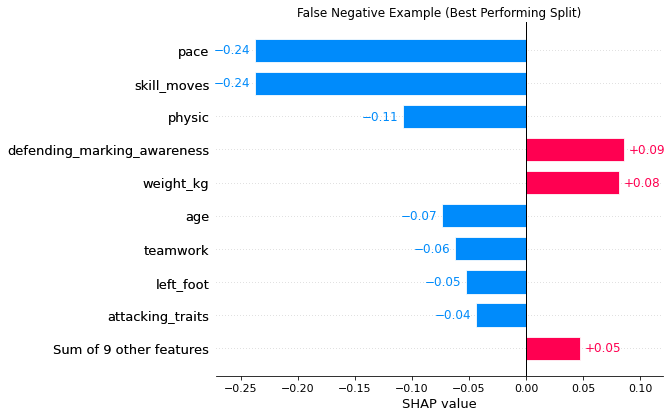

In [143]:
shap.plots.bar(shap_values[76], show=False)
plt.title("False Negative Example (Best Performing Split)");

In [144]:
X.iloc[676]

age                             26.80
height_cm                      182.20
weight_kg                       74.05
skill_moves                      2.25
pace                            65.15
physic                          65.60
movement_balance                63.10
power_jumping                   66.60
mentality_penalties             48.20
defending_marking_awareness     47.85
right_foot                       4.55
left_foot                        3.35
injury_risk                      0.15
teamwork                         0.00
passing_traits                   0.15
attacking_traits                 0.10
dribbling_traits                 0.00
defending_traits                 0.00
Name: 748, dtype: float64

In [90]:
X.pace.describe()

count    1021.000000
mean       69.716161
std         3.397427
min        59.850000
25%        67.200000
50%        69.550000
75%        71.950000
max        78.600000
Name: pace, dtype: float64